In [62]:
import asyncio
from copra.websocket import Channel, Client
import matplotlib.pyplot as plt
from collections import OrderedDict
from time import sleep
from dateutil import parser
import copy
import datetime
import itertools
from operator import itemgetter
import numpy as np
from dateutil.tz import tzutc
import math
import pytz
from pytz import timezone
import pickle
import pylab
from scipy.stats import probplot,expon,kstest
import matplotlib.pyplot as plt
import json
from datetime import timedelta
import pandas as pd
from scipy.stats.stats import pearsonr

# Load Data

In [5]:
def parse_file_json(file_name):
    with open(file_name, "r") as f:
        data = [json.loads(line) for line in f]
    starting_time = parser.parse(data[0][0])
    starting_bids = data[0][1]
    starting_asks = data[0][2]
    
    raw_updates = data[1:]
    
    Bids = {}
    Asks = {}    
    
    updates = []
    
    for price, amount in starting_bids:
        Bids[int(round((float(price)*100)))] = float(amount)
    for price, amount in starting_asks:
        Asks[int(round((float(price)*100)))] = float(amount)
        
    for u in raw_updates:
        price = int(round((float(u["price"])*100)))  
        side = u["side"]
        amount = float(u["amount"])
        time = parser.parse(u["time"])
        
        if side == "buy":
            change = amount - Bids.get(price,0)
        else:
            change = amount - Asks.get(price,0)
        
        updates.append({\
            "Bids": copy.copy(Bids), \
            "Asks": copy.copy(Asks), \
            "time": time, \
            "side": side, \
            "price": price, \
            "change": change            
        })
        
        if side == "buy":
            if amount == "0":
                del Bids[price]
            else:
                Bids[price] = float(amount)
        else:
            if amount == "0":
                del Asks[price]
            else:
                Asks[price] = float(amount)   

    return(starting_time, updates)

In [6]:
def shortened_updates(file_name,K):
    starting_time, updates = parse_file_json(file_name)
    
    res = []
    
    # Caluclate first reference price
    starting_bids = updates[0]['Bids']
    starting_asks = updates[0]['Asks']
    sorted_bids = list(reversed(sorted(starting_bids.items())))
    sorted_asks = list(sorted(starting_asks.items()))        
    best_bid = sorted_bids[0][0]
    best_ask = sorted_asks[0][0]
    if ((best_bid + best_ask) % 2) != 0:
        old_reference_price = round((best_bid+best_ask)/2, 1)
    else:
        old_reference_price = round((best_bid+best_ask+1)/2, 1)
            
    for u in updates:      
        # Find reference price
        sorted_bids = list(reversed(sorted(u['Bids'].items())))
        sorted_asks = list(sorted(u['Asks'].items()))        
        best_bid = sorted_bids[0][0]
        best_ask = sorted_asks[0][0]
        if ((best_bid + best_ask) % 2) != 0:
            reference_price = round((best_bid+best_ask)/2, 1)
        else:
            middle = (best_bid+best_ask)/2
            if old_reference_price > middle:
                reference_price = round((best_bid+best_ask)/2 + 0.5,1)
            else:
                old_reference_price = round((best_bid+best_ask)/2 - 0.5,1)
                
        shortened_book = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
        first_bid = int(round(reference_price - 0.5))
        first_ask = int(round(reference_price + 0.5))        
        for k in range(-K,0):
            shortened_book[k] = u['Bids'].get(first_bid + k + 1,0)
        for k in range(1,K+1):
            shortened_book[k] = u['Asks'].get(first_ask + k - 1,0)
            
        # Find k from the price. Keep track of event if
        # abs(k) <= K
        price = u["price"]
        k = price - reference_price
        if k < 0:
            k = int(round(k - 0.5))
        else:
            k = int(round(k + 0.5))
        if abs(k) <= K:                 
            res.append({
                'reference_price': reference_price,
                'LOB': copy.copy(shortened_book),
                'k': k,
                'change': u['change'],
                'time': u['time']
            })
        
        old_reference_price = reference_price

    return starting_time, res

starting_time,updates = shortened_updates('12_27_18_data.json',10)
len(updates)

115864

# Combine Updates that Occur At Same Time

In [7]:
grouped_by_time = OrderedDict([(k, list(v)) for k, v in itertools.groupby(updates, key=lambda x:x['time'])])
# Contains dictionary of time, reference price, order book, list of changes
cleaned_updates = []
for t, us in grouped_by_time.items():
    if len(us) == 1:
        u = us[0]
        cleaned_updates.append(copy.copy(u))
    else:
        new_update = {'time': t}
        us = sorted(us, key=lambda u:-abs(u['k']))
        grouped_by_k = OrderedDict((k, list(v)) for k, v in itertools.groupby(us, key=lambda u:u['k']))
        reference_k = list(grouped_by_k.keys())[0]
        new_update['reference_price'] = grouped_by_k[reference_k][0]['reference_price']
        new_update['LOB'] = copy.copy(grouped_by_k[reference_k][0]['LOB'])
        events = []
        for k in grouped_by_k:
            combined_change = 0
            for u in grouped_by_k[k]:
                combined_change = combined_change + u['change']
            events.append((k,combined_change))
        for k,change in events:
            new_update = copy.deepcopy(new_update)
            new_update['k'] = k
            new_update['change'] = change
            cleaned_updates.append(new_update)

cleaned_updates
len(cleaned_updates)

114493

# Combine Orders that Occur in Quick Succession
### (Orders that occur within 0.01 seconds of each other)

In [8]:
combined_updates = []
i = 0
while i < len(cleaned_updates):
    reference_price = cleaned_updates[i]['reference_price']
    j = i
    updates_at_reference = []
    while (j < len(cleaned_updates)) and (cleaned_updates[j]['reference_price'] == reference_price):
        updates_at_reference.append(cleaned_updates[j])
        j += 1
    updates_at_reference = sorted(updates_at_reference,key=lambda u:u['k'])
    grouped_by_k = OrderedDict((k, list(v)) for k, v in itertools.groupby(updates_at_reference, key=lambda u:u['k']))
    for k,us in grouped_by_k.items():
        us = copy.deepcopy(sorted(us,key=lambda u:u['time']))
        keep_index = [True for u in us]
        for m in reversed(range(1,len(us))):
            quick_same_order = (us[m]['time'] - us[m-1]['time']).total_seconds() < 0.01
            same_sign = (us[m]['change'] * us[m-1]['change']) > 0
            if quick_same_order and same_sign:
                us[m-1]['change'] += us[m]['change']
                keep_index[m] = False
        for (u,keep) in zip(us, keep_index):
            if keep:
                combined_updates.append(u)
    i = j + 1
    
combined_updates = sorted(combined_updates,key=lambda u:u['time'])
len(combined_updates)

107244

# Calculate Average Event Size at Each Position

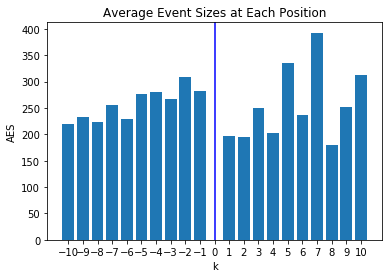

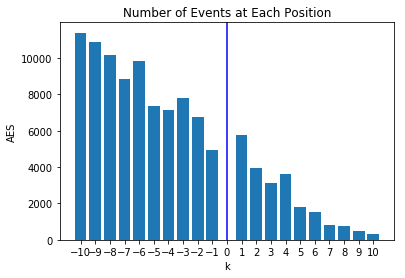

In [9]:
K = 10
starting_ref_price = 457.5
# Get Average Event Sizes
event_sizes = OrderedDict([(i,[]) for i in range(-K,K+1) if i != 0])
for update in combined_updates:
    event_sizes[update['k']].append(abs(update['change']))
AESs = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
numbers_of_events = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
for (k,event_sizes) in event_sizes.items():
    AESs[k] = np.mean(event_sizes)
    numbers_of_events[k] = len(event_sizes)
    
k,AES = zip(*AESs.items())
        
b1 = plt.bar(k, AES)
v = plt.axvline(x=0, color='b')
plt.xticks([i for i in range(-K,K+1)])        
plt.title('Average Event Sizes at Each Position')
plt.xlabel('k')
plt.ylabel('AES')
plt.show()

k,number_of_events = zip(*numbers_of_events.items())
b1 = plt.bar(k, number_of_events)
v = plt.axvline(x=0, color='b')
plt.xticks([i for i in range(-K,K+1)])        
plt.title('Number of Events at Each Position')
plt.xlabel('k')
plt.ylabel('AES')
plt.show()

# Get time between events at each position and queue size

In [48]:
def transform_book(book):
    res = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
    for k,actual_size in book.items():
        if math.isnan(AESs[k]):
            size = 1
        else:
            size = int(actual_size / AESs[k])
        res[k] = size
    return res

# Get times between events
maximum_sizes = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
for update in combined_updates:
    transformed_book = transform_book(update['LOB'])
    for k,size in transformed_book.items():
        if size > maximum_sizes[k]:
            maximum_sizes[k] = size
            
time_between_events_pos = OrderedDict([(k,OrderedDict()) for k in range(-K,K+1) if k != 0])
time_between_events_neg = OrderedDict([(k,OrderedDict()) for k in range(-K,K+1) if k != 0])

for k in range(-K,K+1):
    if k != 0:
        for i in range(maximum_sizes[k] + 1):
            time_between_events_pos[k][i] = []
        for i in range(1,maximum_sizes[k] + 1):
            time_between_events_neg[k][i] = []           
                
t = starting_time
reference_change_time = t
last_change_time_at_k = OrderedDict([(k,reference_change_time) for k in range(-K,K+1) if k != 0])
old_reference_price = starting_ref_price

for update in combined_updates:
    reference_price = update['reference_price']
    transformed_book = transform_book(update['LOB'])
    t = update['time']
    if reference_price != old_reference_price:
        last_change_time_at_k = OrderedDict([(k,reference_change_time) for k in range(-K,K+1) if k != 0])
        reference_change_time = t
        old_reference_price = reference_price

    k = update['k']
    time_between_change = (t-last_change_time_at_k[k]).total_seconds()
    size = transformed_book[k]
    if update['change'] > 0:
        time_between_events_pos[k][size].append(time_between_change)
        last_change_time_at_k[k]= t
    else:
        if size > 0:
            time_between_events_neg[k][size].append(time_between_change)
            last_change_time_at_k[k] = t 

# QQ Plots of Times Between Events Compared to Exponential Distribution

k = -10, size = 0
Number of positive jump times: 3509
Mean: 1.8383901396409235


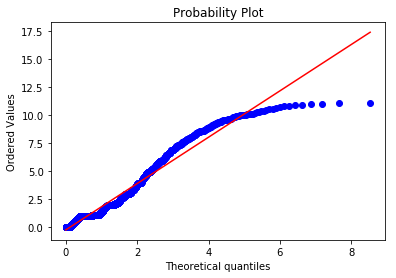



k = -10, size = 1
Number of positive jump times: 339
Mean: 1.0926696165191738


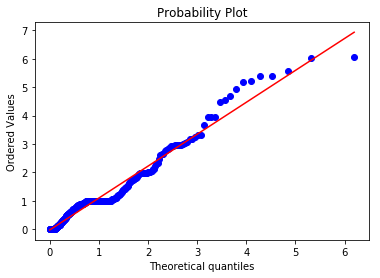



k = -10, size = 2
Number of positive jump times: 212
Mean: 2.6397216981132074


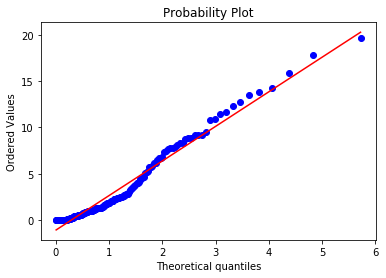



k = -10, size = 3
Number of positive jump times: 112
Mean: 2.3020892857142856


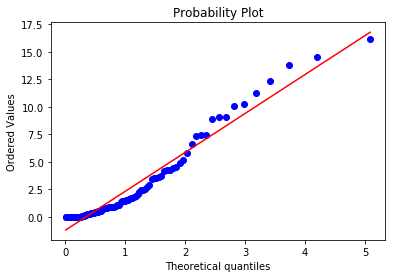



k = -10, size = 4
Number of positive jump times: 144
Mean: 1.2686527777777776


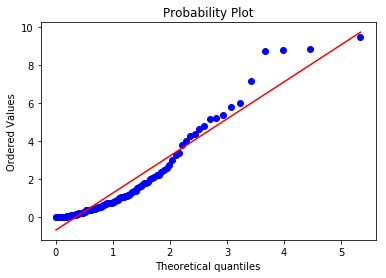



k = -10, size = 5
Number of positive jump times: 106
Mean: 2.8988113207547164


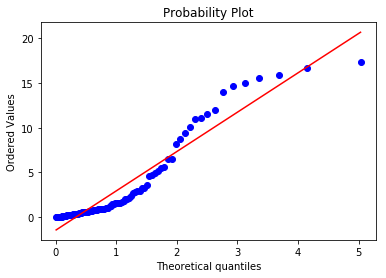



k = -10, size = 6
Number of positive jump times: 104
Mean: 1.9725576923076922


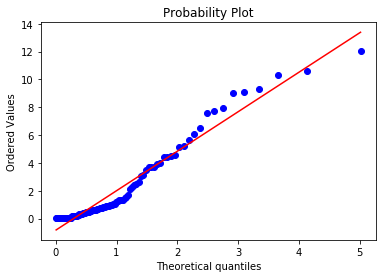



k = -10, size = 7
Number of positive jump times: 102
Mean: 1.217421568627451


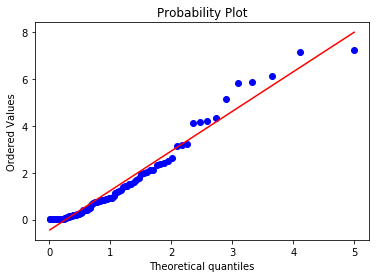



k = -10, size = 8
Number of positive jump times: 63
Mean: 2.5265396825396826


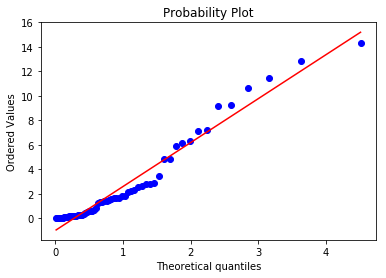



k = -10, size = 9
Number of positive jump times: 41
Mean: 1.3674634146341462


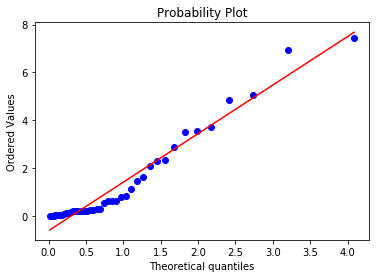



k = -10, size = 10
Number of positive jump times: 41
Mean: 1.5053414634146343


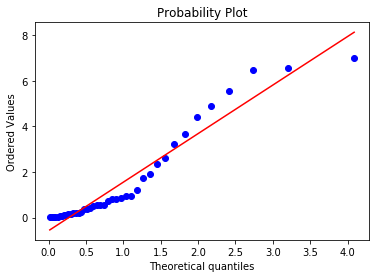



k = -10, size = 11
Number of positive jump times: 32
Mean: 3.4514375


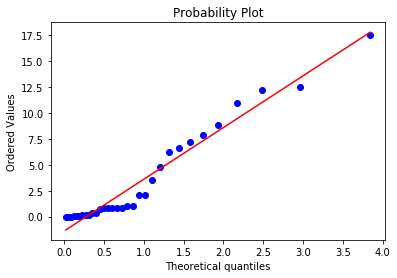



k = -10, size = 22
Number of positive jump times: 61
Mean: 1.244377049180328


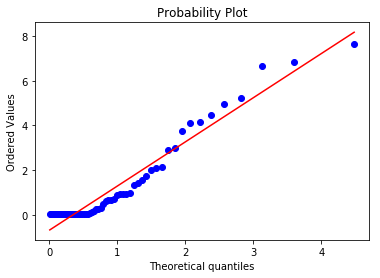



k = -10, size = 23
Number of positive jump times: 44
Mean: 2.702727272727273


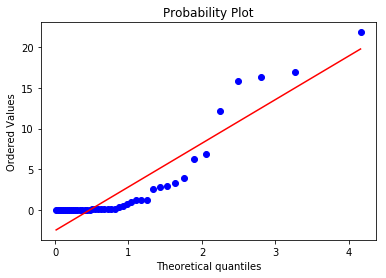



k = -10, size = 25
Number of positive jump times: 29
Mean: 2.7350689655172418


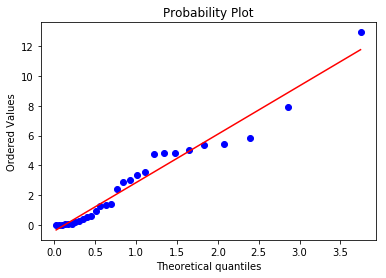



k = -10, size = 26
Number of positive jump times: 24
Mean: 1.4437916666666666


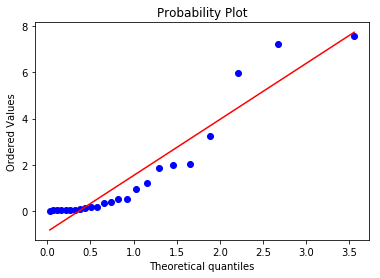



k = -10, size = 27
Number of positive jump times: 24
Mean: 3.2583749999999996


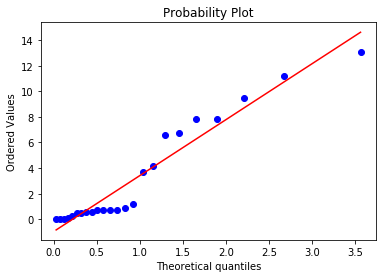



k = -10, size = 28
Number of positive jump times: 33
Mean: 0.5456060606060605


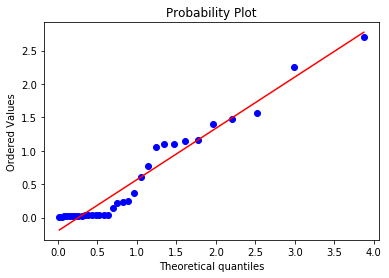



k = -10, size = 30
Number of positive jump times: 30
Mean: 1.4427333333333334


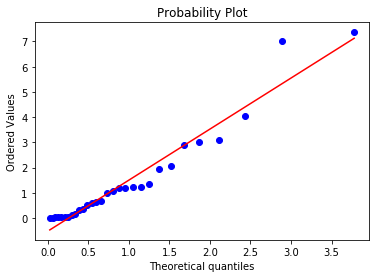



k = -9, size = 0
Number of positive jump times: 3386
Mean: 2.3976255168340224


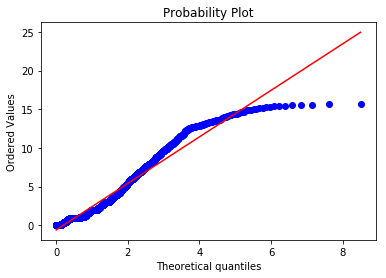



k = -9, size = 1
Number of positive jump times: 351
Mean: 1.2634330484330485


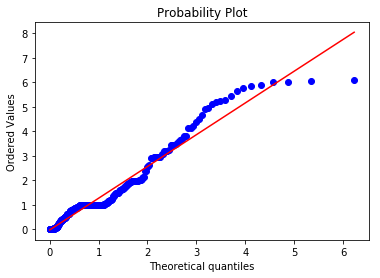



k = -9, size = 2
Number of positive jump times: 205
Mean: 2.1682048780487806


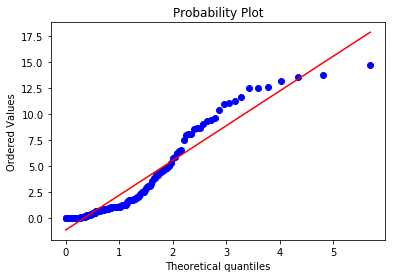



k = -9, size = 3
Number of positive jump times: 145
Mean: 0.4490482758620689


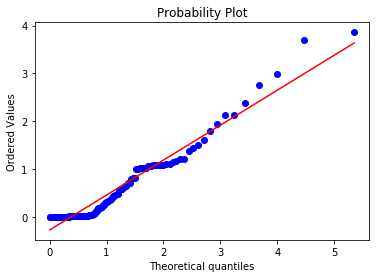



k = -9, size = 4
Number of positive jump times: 135
Mean: 1.7287185185185185


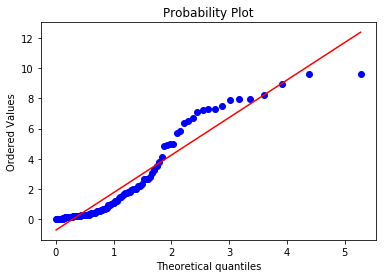



k = -9, size = 5
Number of positive jump times: 95
Mean: 1.1266947368421054


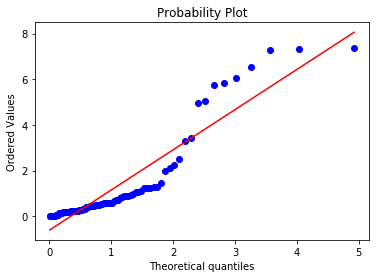



k = -9, size = 6
Number of positive jump times: 97
Mean: 1.1384742268041237


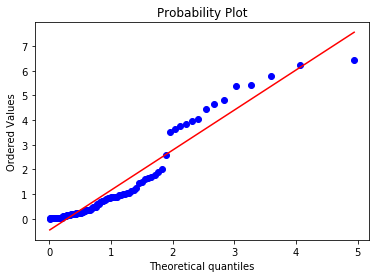



k = -9, size = 7
Number of positive jump times: 76
Mean: 1.0154605263157894


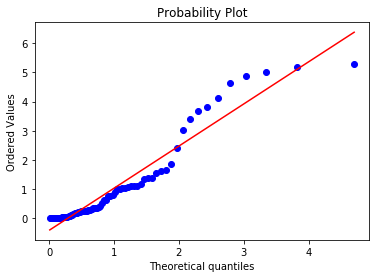



k = -9, size = 8
Number of positive jump times: 54
Mean: 0.8832962962962964


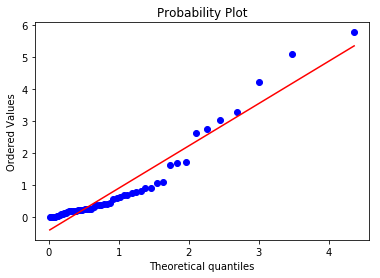



k = -9, size = 9
Number of positive jump times: 46
Mean: 1.1642608695652175


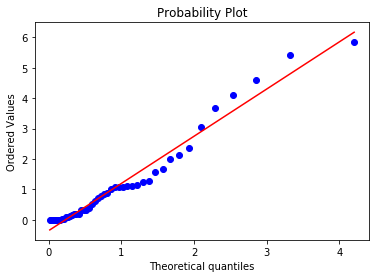



k = -9, size = 10
Number of positive jump times: 24
Mean: 2.8567083333333336


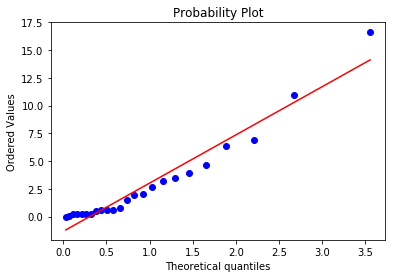



k = -9, size = 23
Number of positive jump times: 49
Mean: 1.8631428571428568


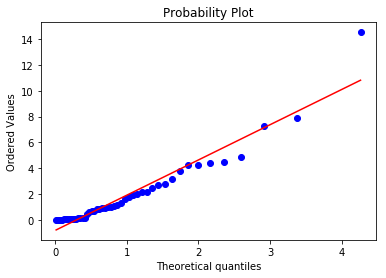



k = -9, size = 24
Number of positive jump times: 28
Mean: 5.266821428571428


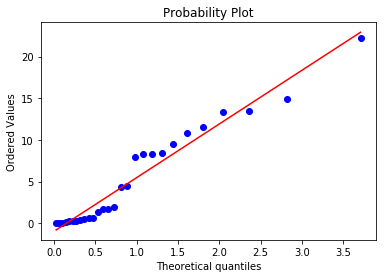



k = -9, size = 25
Number of positive jump times: 28
Mean: 0.7297142857142856


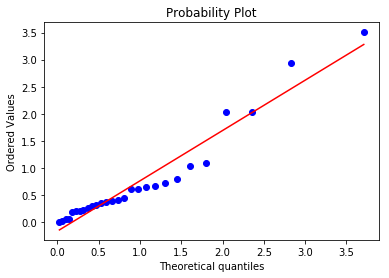



k = -9, size = 26
Number of positive jump times: 89
Mean: 1.2261011235955055


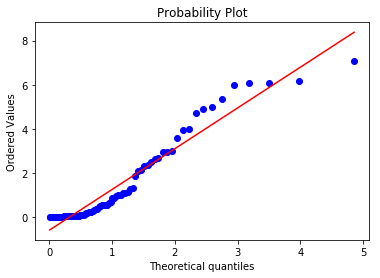



k = -9, size = 28
Number of positive jump times: 65
Mean: 1.1689384615384615


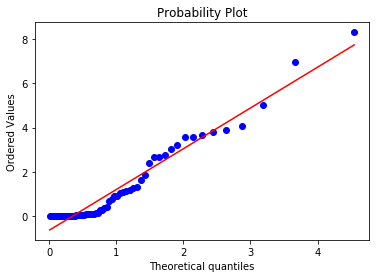



k = -9, size = 29
Number of positive jump times: 22
Mean: 0.5190454545454546


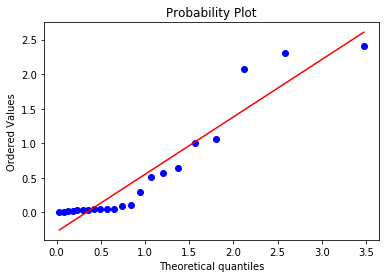



k = -9, size = 33
Number of positive jump times: 23
Mean: 0.7113478260869566


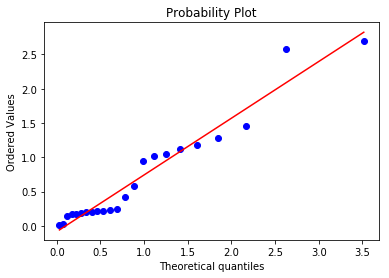



k = -8, size = 0
Number of positive jump times: 3474
Mean: 2.3836744386873914


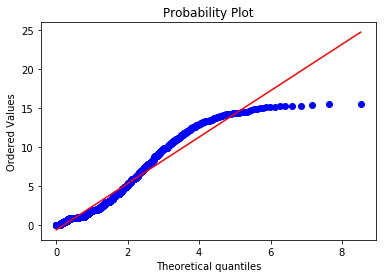



k = -8, size = 1
Number of positive jump times: 225
Mean: 0.7922977777777778


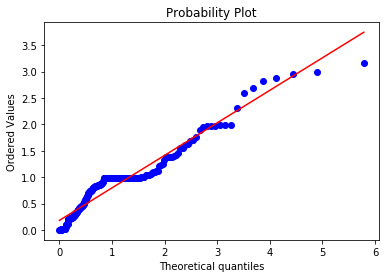



k = -8, size = 2
Number of positive jump times: 172
Mean: 1.8359825581395348


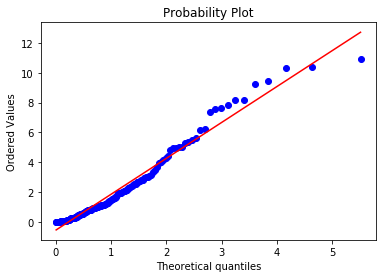



k = -8, size = 3
Number of positive jump times: 82
Mean: 2.089634146341463


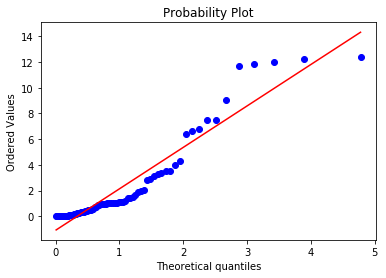



k = -8, size = 4
Number of positive jump times: 112
Mean: 2.5681875000000005


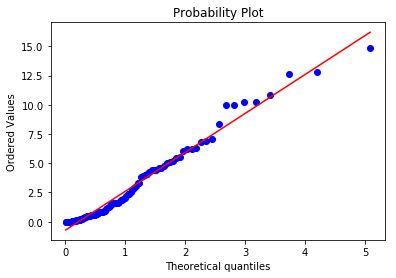



k = -8, size = 5
Number of positive jump times: 64
Mean: 2.6193906250000003


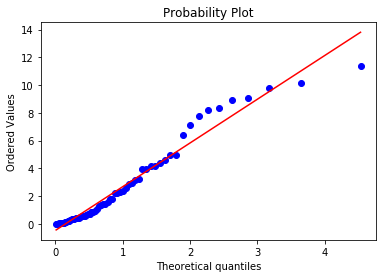



k = -8, size = 6
Number of positive jump times: 44
Mean: 2.1318181818181823


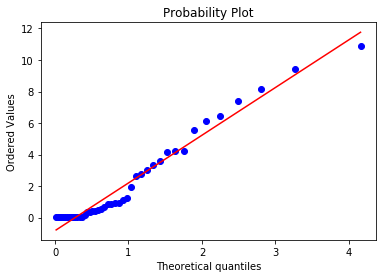



k = -8, size = 7
Number of positive jump times: 52
Mean: 1.8465192307692309


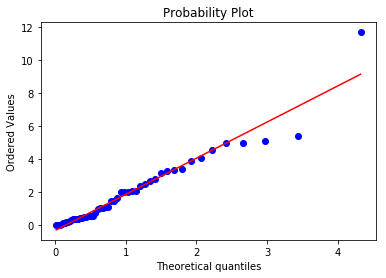



k = -8, size = 8
Number of positive jump times: 45
Mean: 1.1558000000000002


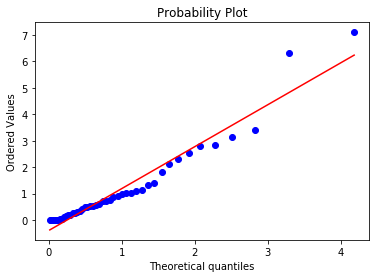



k = -8, size = 9
Number of positive jump times: 51
Mean: 1.2600980392156866


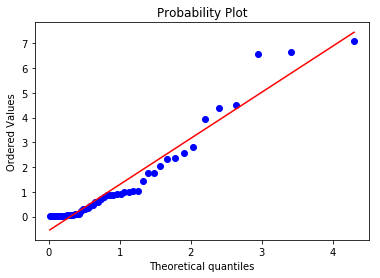



k = -8, size = 10
Number of positive jump times: 32
Mean: 1.79


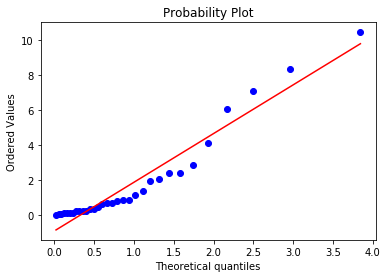



k = -8, size = 11
Number of positive jump times: 39
Mean: 0.4885128205128205


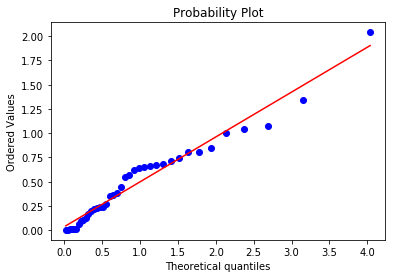



k = -8, size = 12
Number of positive jump times: 26
Mean: 1.387576923076923


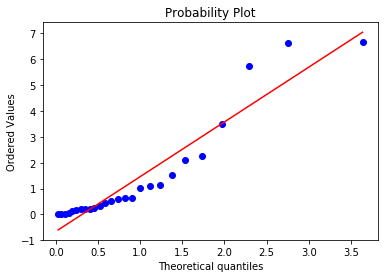



k = -8, size = 22
Number of positive jump times: 30
Mean: 0.44143333333333334


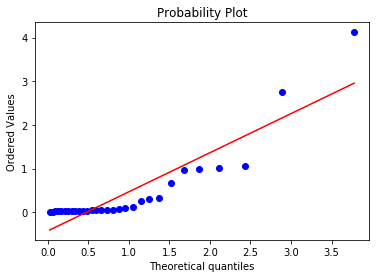



k = -8, size = 24
Number of positive jump times: 32
Mean: 0.6361875


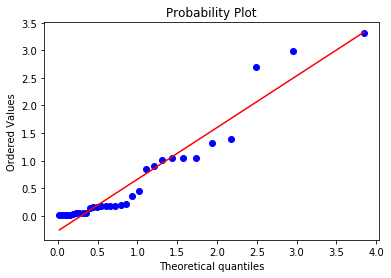



k = -8, size = 25
Number of positive jump times: 54
Mean: 1.3970555555555555


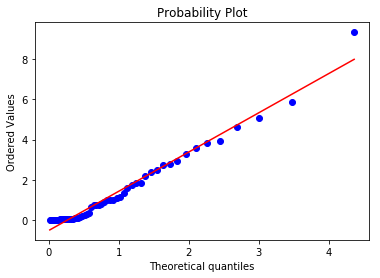



k = -8, size = 27
Number of positive jump times: 40
Mean: 4.003475


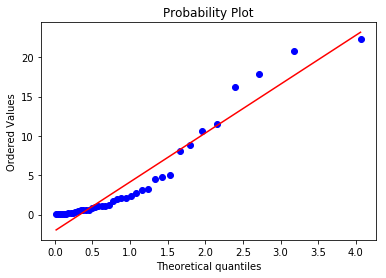



k = -7, size = 0
Number of positive jump times: 2917
Mean: 3.1012790538224206


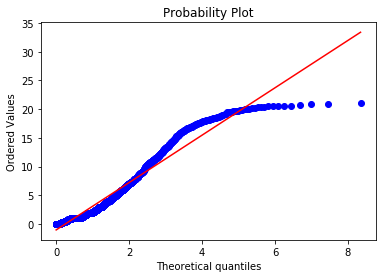



k = -7, size = 1
Number of positive jump times: 341
Mean: 1.641756598240469


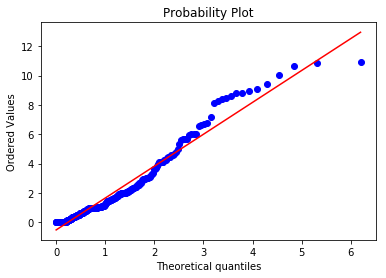



k = -7, size = 2
Number of positive jump times: 188
Mean: 2.1811489361702128


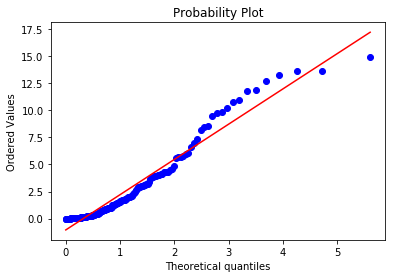



k = -7, size = 3
Number of positive jump times: 171
Mean: 1.498280701754386


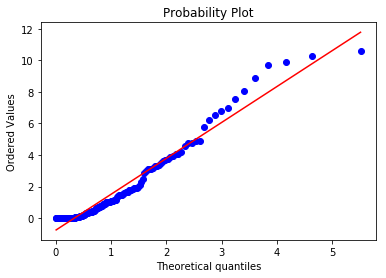



k = -7, size = 4
Number of positive jump times: 97
Mean: 1.7678865979381442


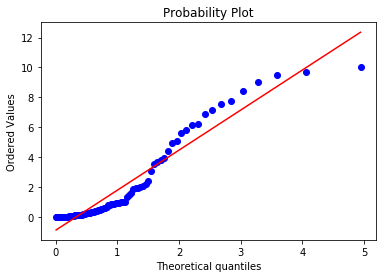



k = -7, size = 5
Number of positive jump times: 100
Mean: 0.88759


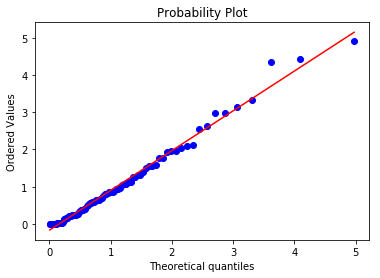



k = -7, size = 6
Number of positive jump times: 46
Mean: 0.6539347826086958


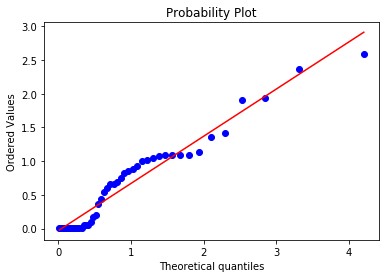



k = -7, size = 7
Number of positive jump times: 30
Mean: 0.6297666666666666


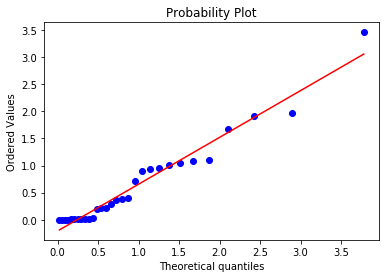



k = -7, size = 8
Number of positive jump times: 26
Mean: 0.43942307692307697


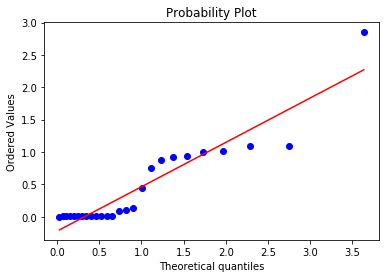



k = -7, size = 20
Number of positive jump times: 23
Mean: 3.4335652173913043


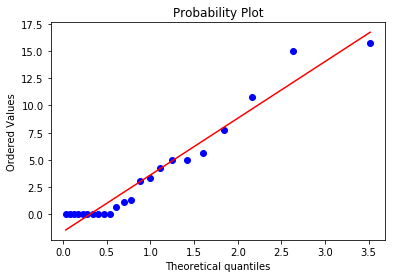



k = -7, size = 21
Number of positive jump times: 26
Mean: 3.857192307692308


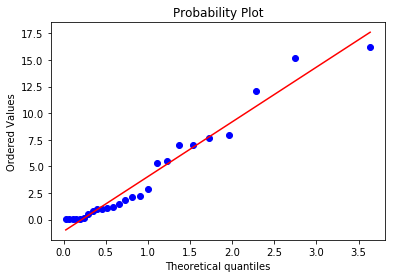



k = -7, size = 23
Number of positive jump times: 22
Mean: 0.6496818181818182


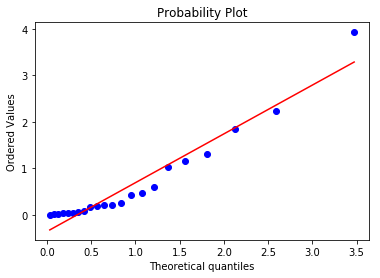



k = -7, size = 25
Number of positive jump times: 21
Mean: 0.9143333333333333


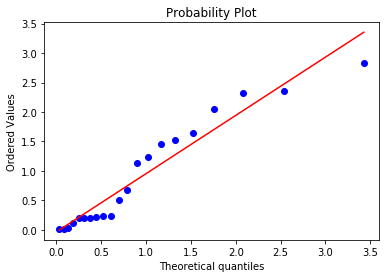



k = -7, size = 26
Number of positive jump times: 29
Mean: 0.47841379310344817


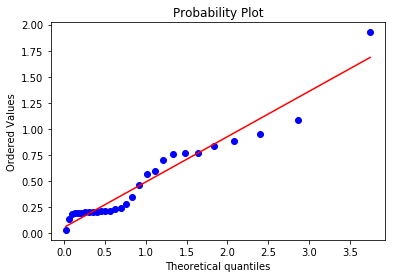



k = -6, size = 0
Number of positive jump times: 3439
Mean: 2.093430357662111


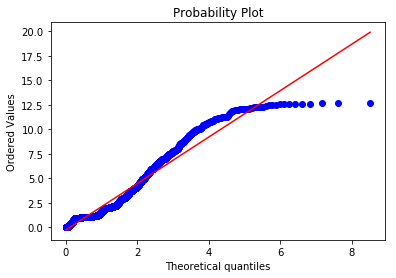



k = -6, size = 1
Number of positive jump times: 261
Mean: 1.0828773946360153


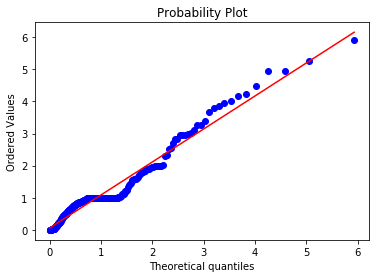



k = -6, size = 2
Number of positive jump times: 95
Mean: 3.203315789473684


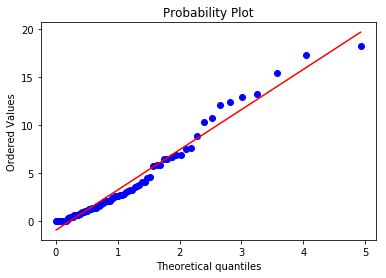



k = -6, size = 3
Number of positive jump times: 67
Mean: 1.7549402985074631


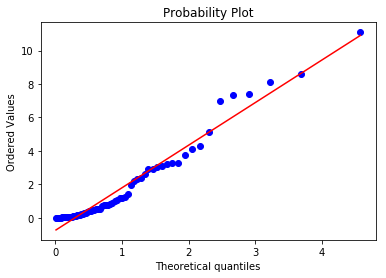



k = -6, size = 4
Number of positive jump times: 57
Mean: 2.489929824561403


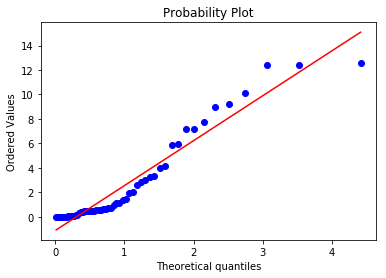



k = -6, size = 5
Number of positive jump times: 38
Mean: 1.648894736842105


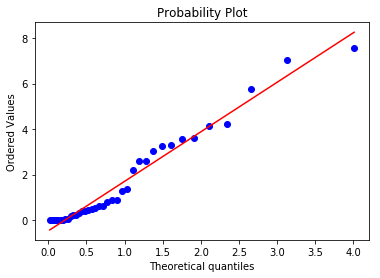



k = -6, size = 7
Number of positive jump times: 42
Mean: 2.375642857142857


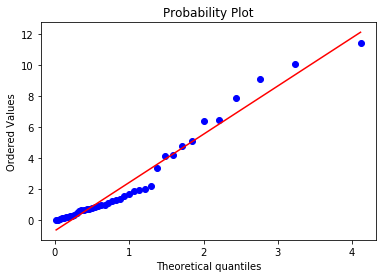



k = -6, size = 9
Number of positive jump times: 35
Mean: 2.816857142857143


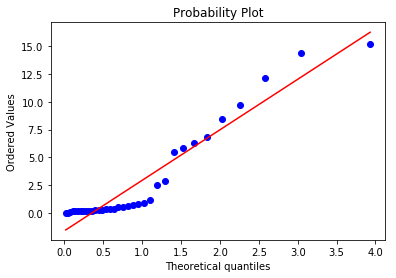



k = -6, size = 12
Number of positive jump times: 32
Mean: 0.9589375


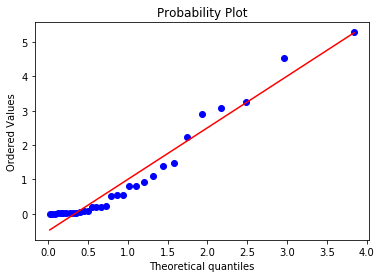



k = -6, size = 13
Number of positive jump times: 31
Mean: 4.230032258064516


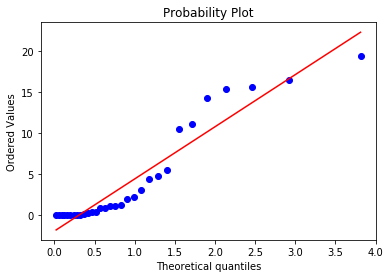



k = -6, size = 22
Number of positive jump times: 40
Mean: 1.091025


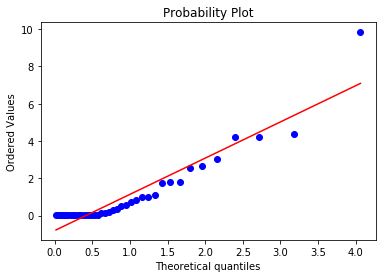



k = -6, size = 23
Number of positive jump times: 63
Mean: 1.2826984126984127


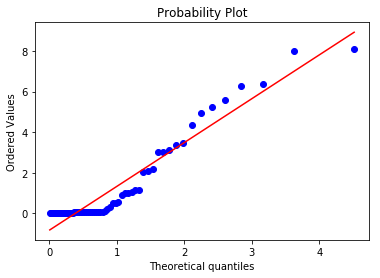



k = -6, size = 24
Number of positive jump times: 96
Mean: 0.5636145833333334


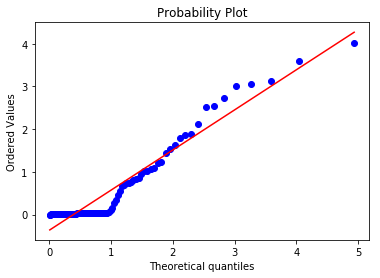



k = -6, size = 25
Number of positive jump times: 22
Mean: 1.277136363636364


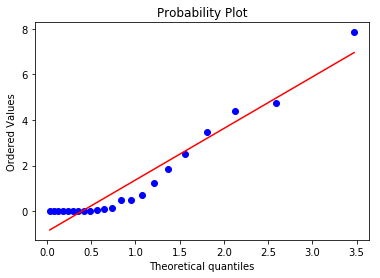



k = -5, size = 0
Number of positive jump times: 2632
Mean: 3.097481762917933


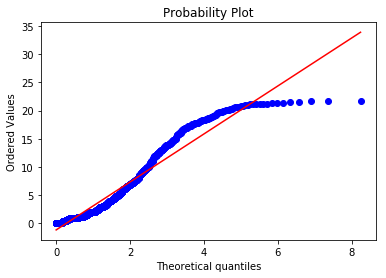



k = -5, size = 1
Number of positive jump times: 104
Mean: 0.9909903846153845


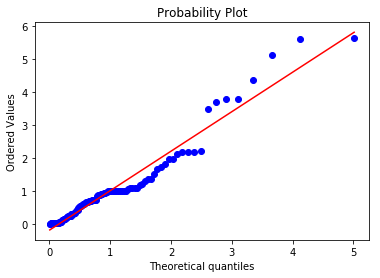



k = -5, size = 2
Number of positive jump times: 134
Mean: 1.46755223880597


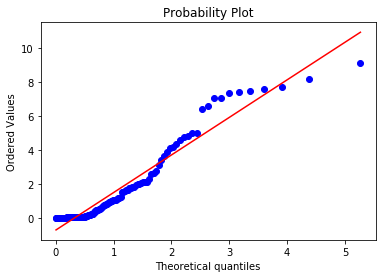



k = -5, size = 3
Number of positive jump times: 59
Mean: 1.5033728813559322


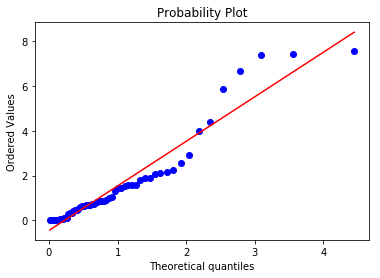



k = -5, size = 4
Number of positive jump times: 21
Mean: 1.196952380952381


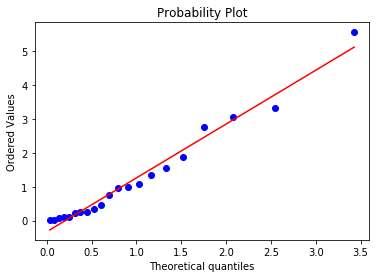



k = -5, size = 5
Number of positive jump times: 80
Mean: 0.7267250000000001


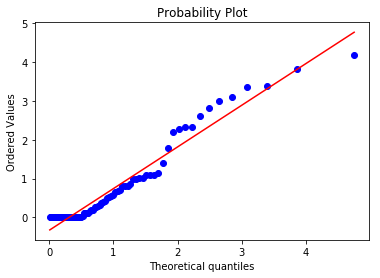



k = -5, size = 6
Number of positive jump times: 42
Mean: 3.186142857142857


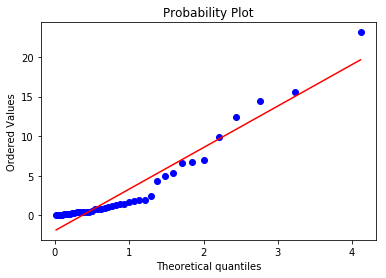



k = -5, size = 7
Number of positive jump times: 32
Mean: 1.2323125


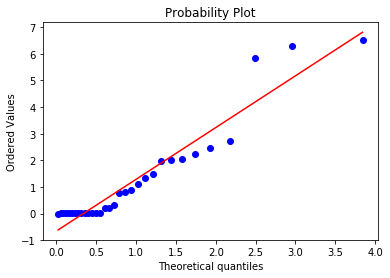



k = -5, size = 9
Number of positive jump times: 29
Mean: 1.891896551724138


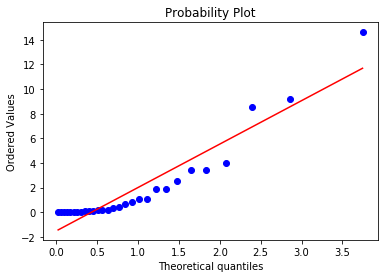



k = -5, size = 18
Number of positive jump times: 39
Mean: 0.7521794871794872


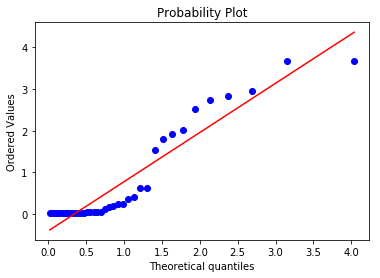



k = -5, size = 19
Number of positive jump times: 23
Mean: 2.9138695652173916


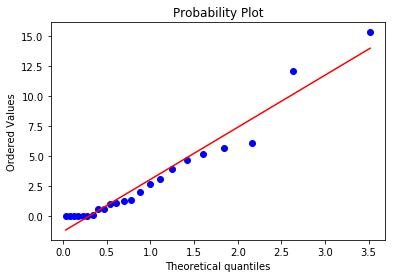



k = -5, size = 20
Number of positive jump times: 22
Mean: 2.6283636363636367


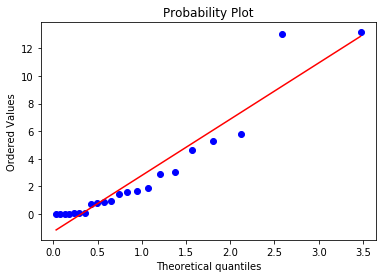



k = -4, size = 0
Number of positive jump times: 2277
Mean: 2.867363197189284


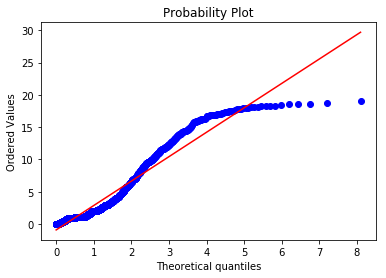



k = -4, size = 1
Number of positive jump times: 192
Mean: 1.0325989583333333


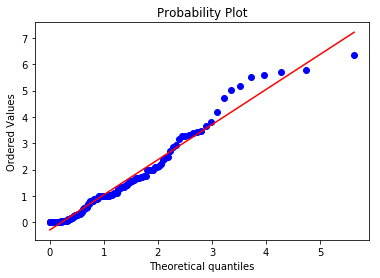



k = -4, size = 2
Number of positive jump times: 74
Mean: 1.0341216216216216


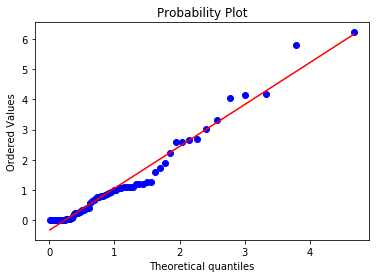



k = -4, size = 3
Number of positive jump times: 67
Mean: 1.7082686567164178


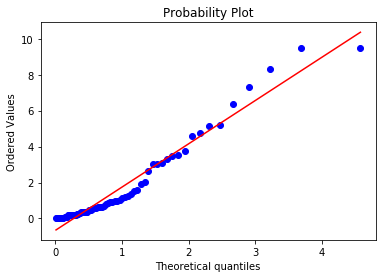



k = -4, size = 4
Number of positive jump times: 76
Mean: 1.9549605263157899


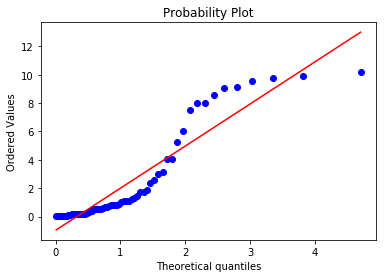



k = -4, size = 5
Number of positive jump times: 33
Mean: 1.1803030303030304


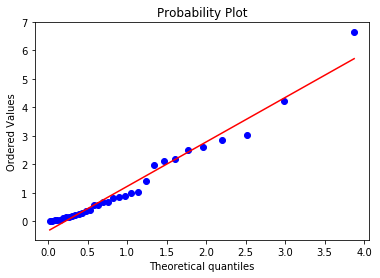



k = -4, size = 17
Number of positive jump times: 168
Mean: 0.6449523809523809


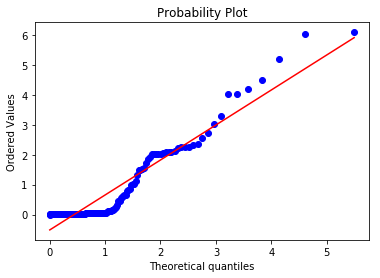



k = -4, size = 18
Number of positive jump times: 110
Mean: 1.1295909090909089


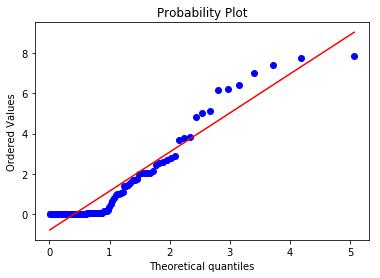



k = -4, size = 19
Number of positive jump times: 70
Mean: 3.4513857142857143


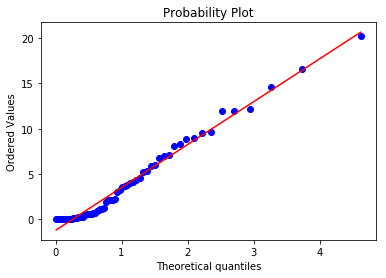



k = -4, size = 21
Number of positive jump times: 35
Mean: 2.8392571428571425


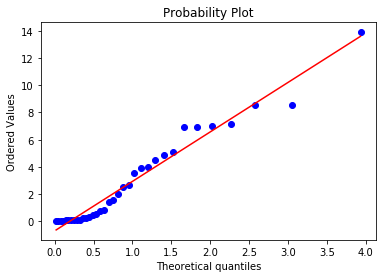



k = -4, size = 22
Number of positive jump times: 24
Mean: 0.48574999999999996


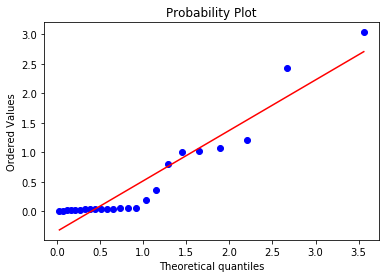



k = -3, size = 0
Number of positive jump times: 2435
Mean: 1.8924328542094457


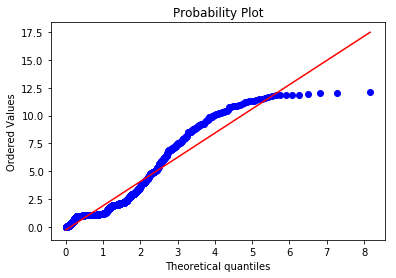



k = -3, size = 1
Number of positive jump times: 139
Mean: 2.374776978417266


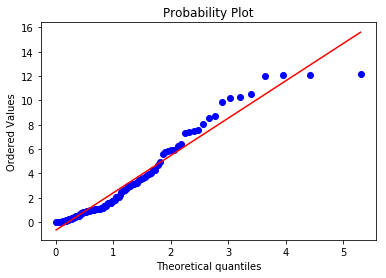



k = -3, size = 2
Number of positive jump times: 136
Mean: 1.287705882352941


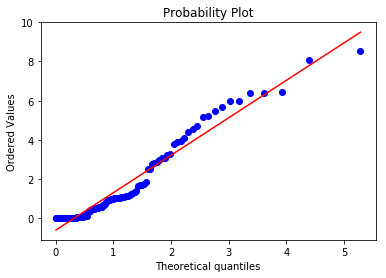



k = -3, size = 3
Number of positive jump times: 73
Mean: 0.6489452054794521


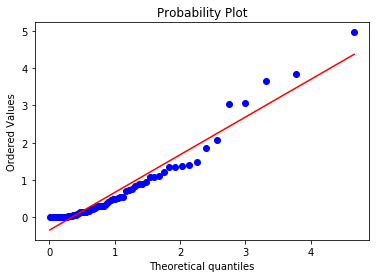



k = -3, size = 4
Number of positive jump times: 76
Mean: 0.612828947368421


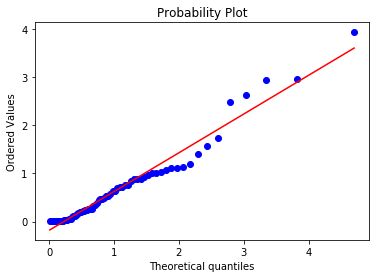



k = -3, size = 5
Number of positive jump times: 74
Mean: 0.6036486486486486


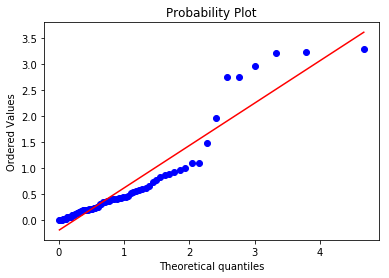



k = -3, size = 6
Number of positive jump times: 78
Mean: 0.8107307692307693


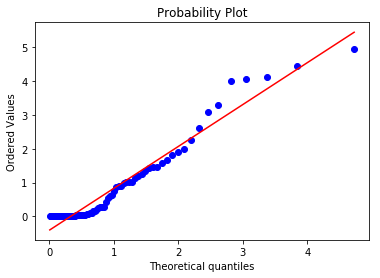



k = -3, size = 7
Number of positive jump times: 32
Mean: 0.6400625


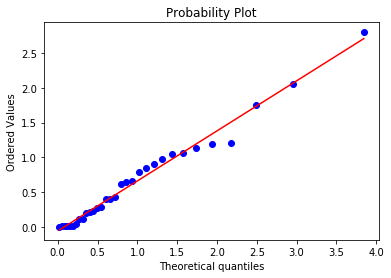



k = -3, size = 8
Number of positive jump times: 46
Mean: 2.119282608695652


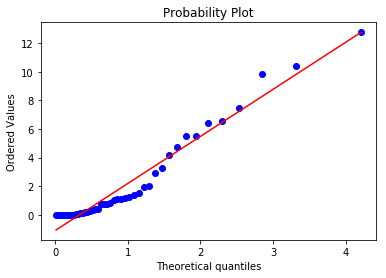



k = -3, size = 10
Number of positive jump times: 29
Mean: 0.4767931034482759


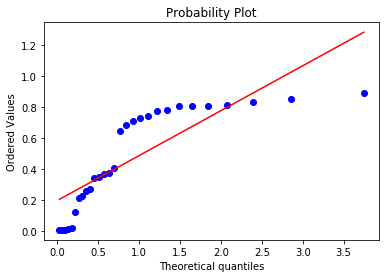



k = -3, size = 18
Number of positive jump times: 28
Mean: 1.1714285714285715


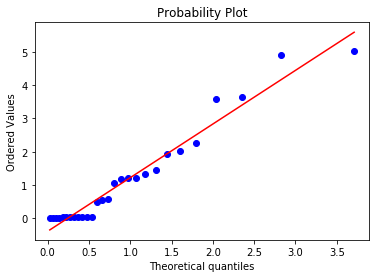



k = -3, size = 20
Number of positive jump times: 164
Mean: 0.974298780487805


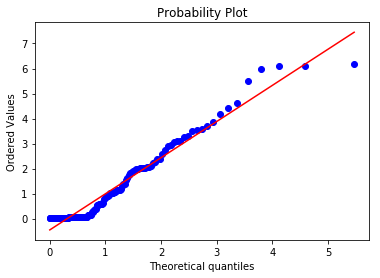



k = -3, size = 21
Number of positive jump times: 27
Mean: 1.237148148148148


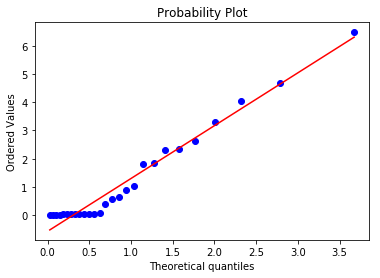



k = -3, size = 22
Number of positive jump times: 38
Mean: 1.1486842105263158


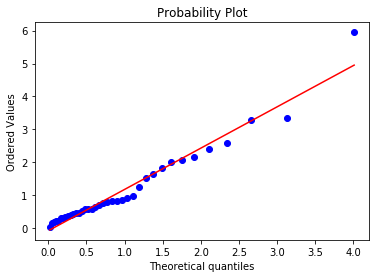



k = -3, size = 23
Number of positive jump times: 24
Mean: 0.4455


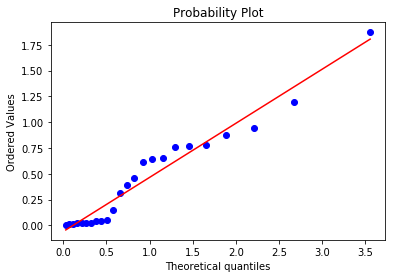



k = -2, size = 0
Number of positive jump times: 1800
Mean: 2.075041651666667


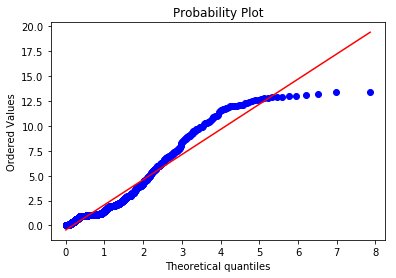



k = -2, size = 1
Number of positive jump times: 222
Mean: 1.2948783783783782


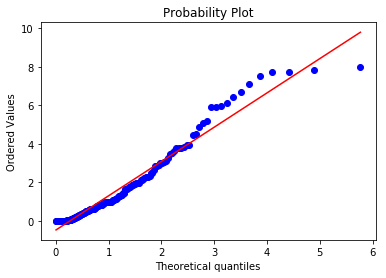



k = -2, size = 2
Number of positive jump times: 143
Mean: 0.7582167832167833


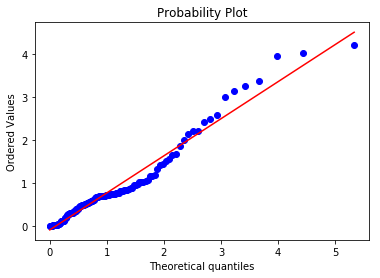



k = -2, size = 3
Number of positive jump times: 217
Mean: 1.1603870967741934


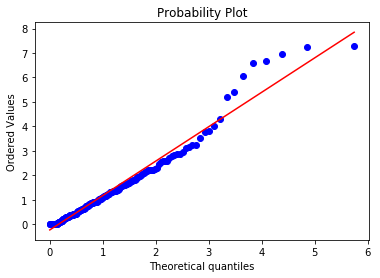



k = -2, size = 4
Number of positive jump times: 167
Mean: 1.0499221556886227


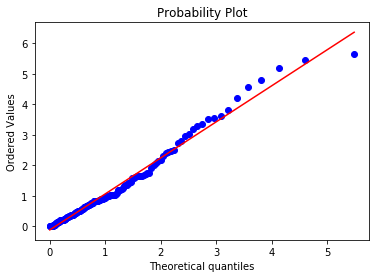



k = -2, size = 5
Number of positive jump times: 67
Mean: 0.6487611940298508


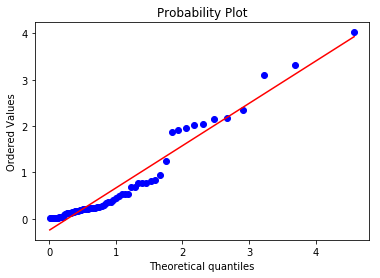



k = -2, size = 6
Number of positive jump times: 46
Mean: 0.35343478260869565


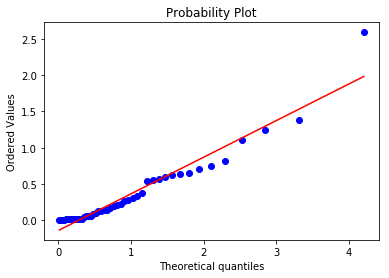



k = -2, size = 7
Number of positive jump times: 47
Mean: 0.6266170212765958


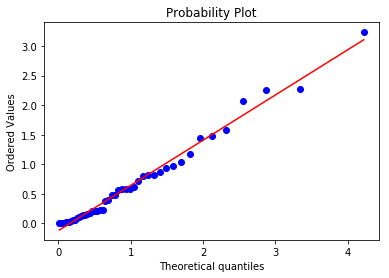



k = -2, size = 8
Number of positive jump times: 38
Mean: 2.18471052631579


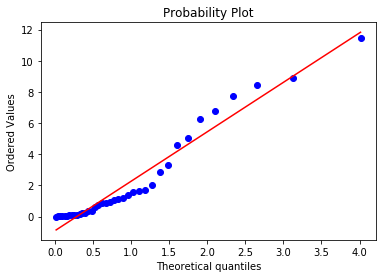



k = -2, size = 9
Number of positive jump times: 31
Mean: 1.6922580645161294


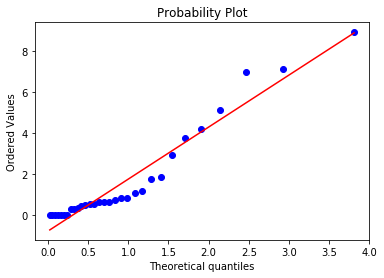



k = -2, size = 16
Number of positive jump times: 93
Mean: 0.6912580645161291


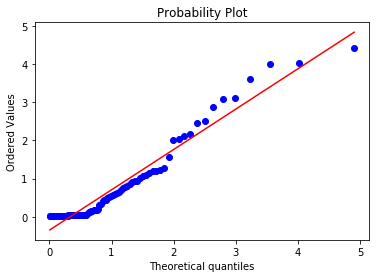



k = -2, size = 22
Number of positive jump times: 33
Mean: 1.2929090909090908


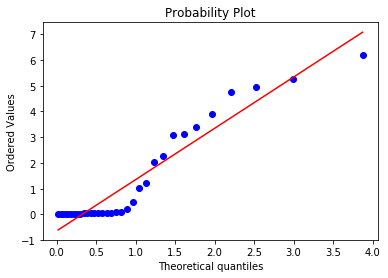



k = -2, size = 23
Number of positive jump times: 22
Mean: 1.9791818181818182


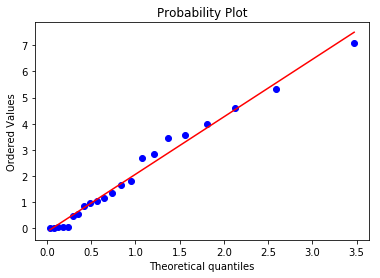



k = -2, size = 38
Number of positive jump times: 27
Mean: 0.04696296296296296


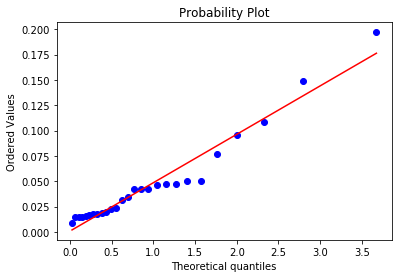



k = -1, size = 0
Number of positive jump times: 1426
Mean: 3.022374474053296


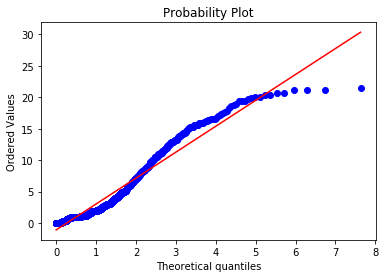



k = -1, size = 1
Number of positive jump times: 145
Mean: 1.1915310344827585


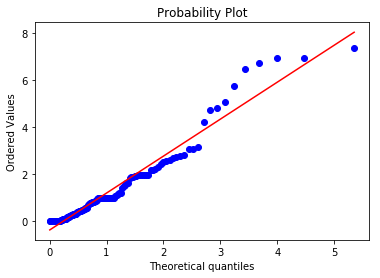



k = -1, size = 2
Number of positive jump times: 144
Mean: 1.216875


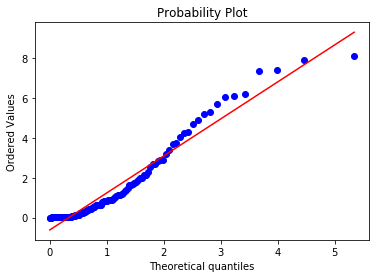



k = -1, size = 3
Number of positive jump times: 71
Mean: 1.5260704225352115


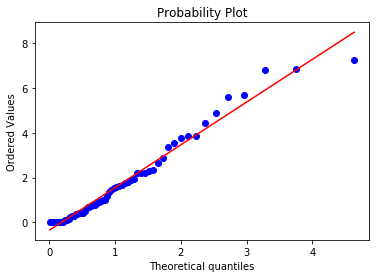



k = -1, size = 4
Number of positive jump times: 86
Mean: 1.8242441860465115


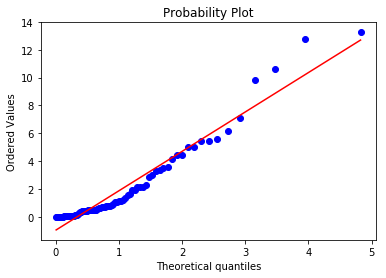



k = -1, size = 5
Number of positive jump times: 69
Mean: 1.458072463768116


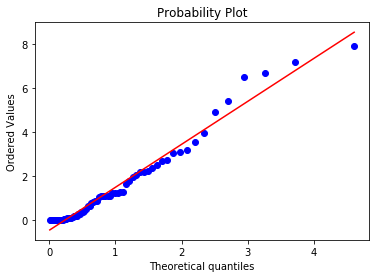



k = -1, size = 6
Number of positive jump times: 79
Mean: 1.631898734177215


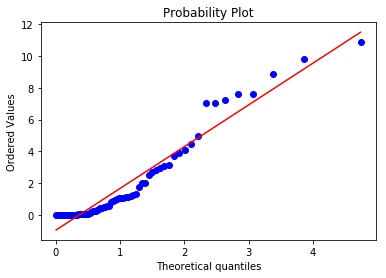



k = -1, size = 17
Number of positive jump times: 26
Mean: 0.6653461538461538


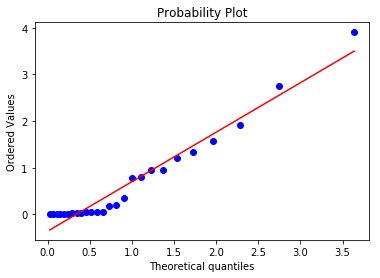



k = -1, size = 18
Number of positive jump times: 25
Mean: 0.17608000000000001


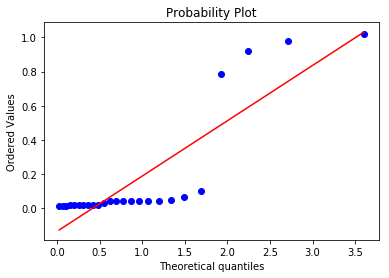



k = -1, size = 21
Number of positive jump times: 49
Mean: 1.7990408163265308


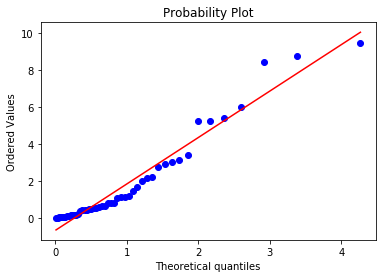



k = -1, size = 23
Number of positive jump times: 40
Mean: 0.731325


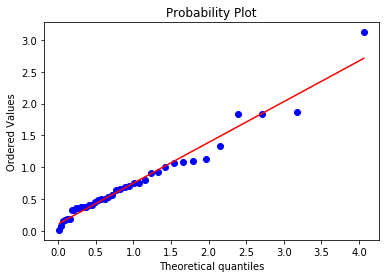



k = -1, size = 24
Number of positive jump times: 23
Mean: 2.4800869565217387


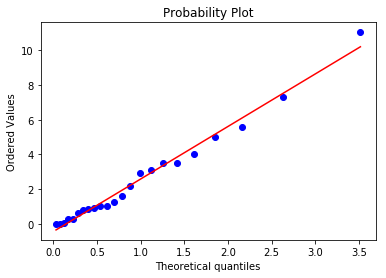



k = 1, size = 0
Number of positive jump times: 1661
Mean: 2.1001986754966886


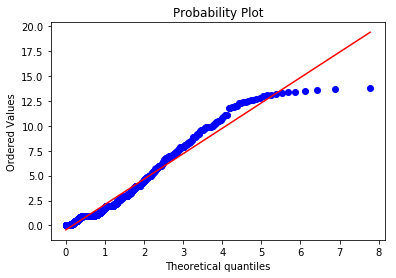



k = 1, size = 1
Number of positive jump times: 302
Mean: 0.7858708609271523


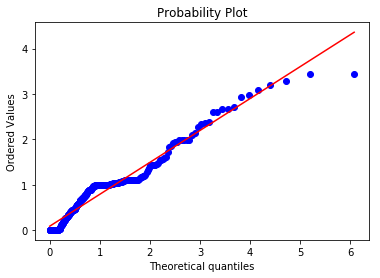



k = 1, size = 2
Number of positive jump times: 115
Mean: 0.8954434782608696


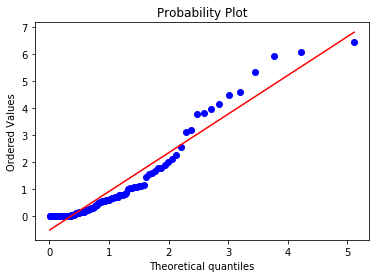



k = 1, size = 3
Number of positive jump times: 147
Mean: 0.4026190476190476


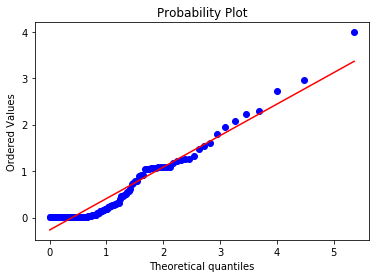



k = 1, size = 4
Number of positive jump times: 82
Mean: 1.6170365853658537


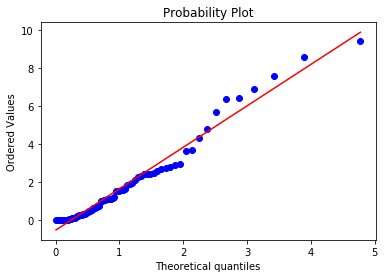



k = 1, size = 5
Number of positive jump times: 107
Mean: 1.0472710280373831


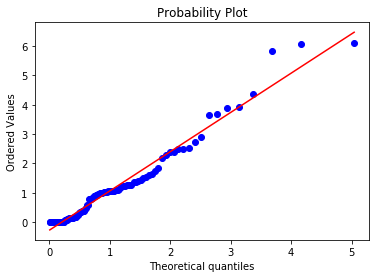



k = 1, size = 6
Number of positive jump times: 53
Mean: 0.843830188679245


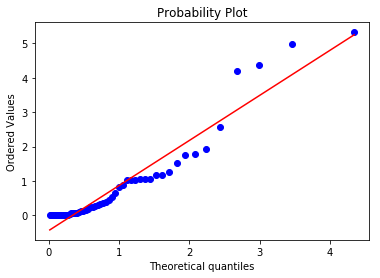



k = 1, size = 7
Number of positive jump times: 29
Mean: 0.7037241379310345


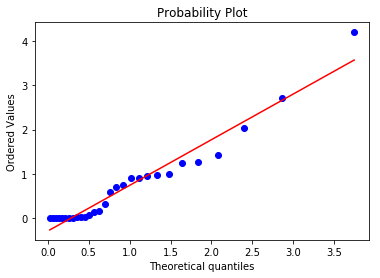



k = 1, size = 8
Number of positive jump times: 25
Mean: 0.9429599999999999


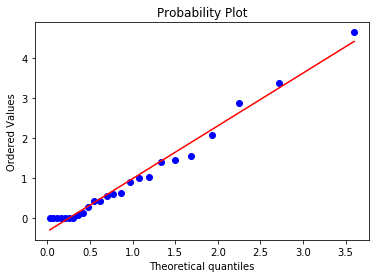



k = 2, size = 0
Number of positive jump times: 1019
Mean: 2.7558616290480864


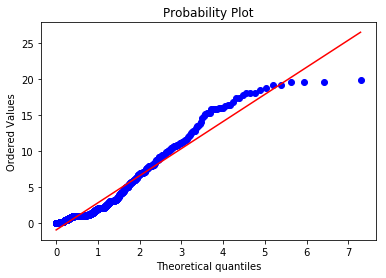



k = 2, size = 1
Number of positive jump times: 239
Mean: 0.6767531380753137


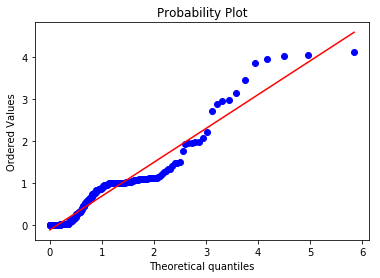



k = 2, size = 2
Number of positive jump times: 201
Mean: 2.2465621890547265


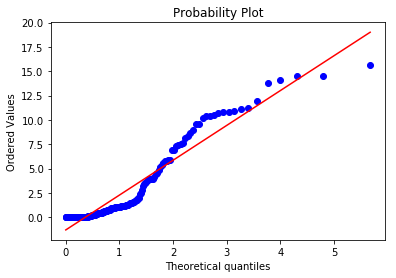



k = 2, size = 3
Number of positive jump times: 88
Mean: 1.9021818181818184


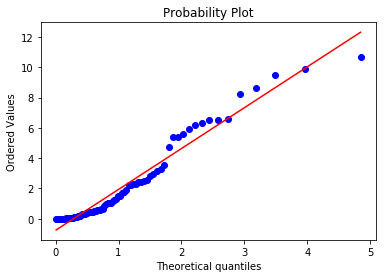



k = 2, size = 4
Number of positive jump times: 58
Mean: 39.47484482758621


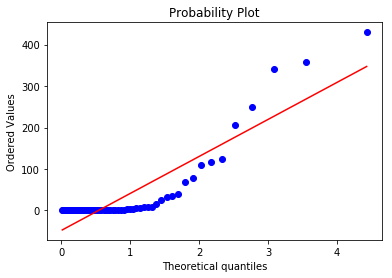



k = 2, size = 5
Number of positive jump times: 43
Mean: 0.45062790697674415


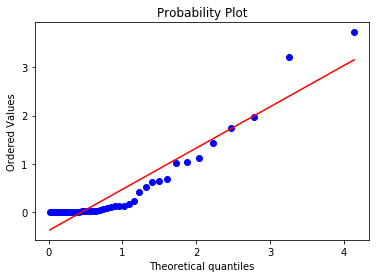



k = 2, size = 6
Number of positive jump times: 24
Mean: 0.630625


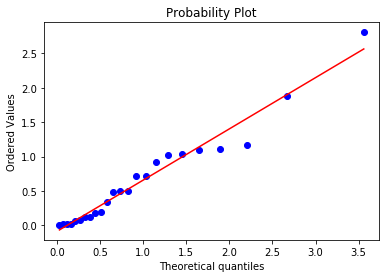



k = 2, size = 7
Number of positive jump times: 37
Mean: 0.33416216216216216


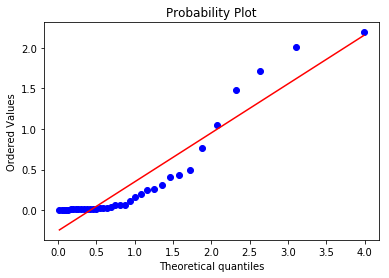



k = 3, size = 0
Number of positive jump times: 707
Mean: 3.6394101838755306


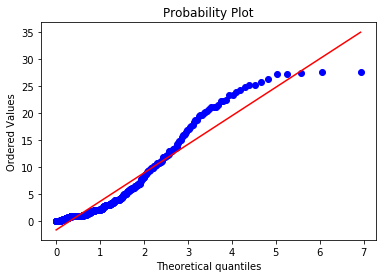



k = 3, size = 1
Number of positive jump times: 122
Mean: 1.1290409836065576


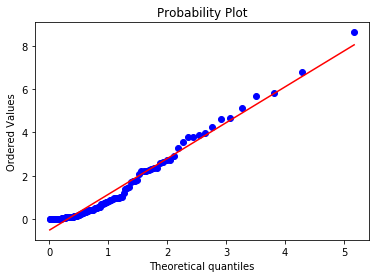



k = 3, size = 2
Number of positive jump times: 166
Mean: 1.0575180722891566


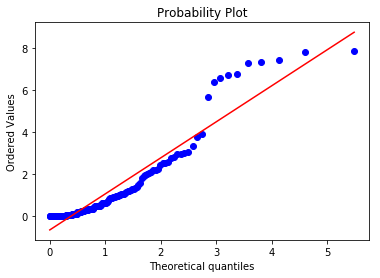



k = 3, size = 3
Number of positive jump times: 85
Mean: 0.8751529411764705


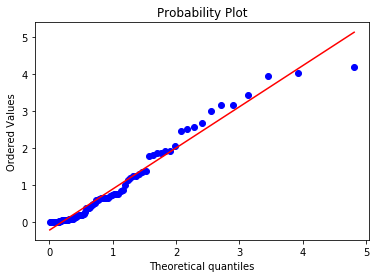



k = 3, size = 4
Number of positive jump times: 48
Mean: 2.5194375


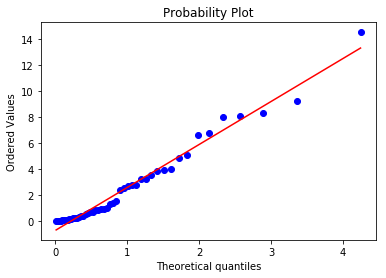



k = 3, size = 5
Number of positive jump times: 72
Mean: 2.4446805555555553


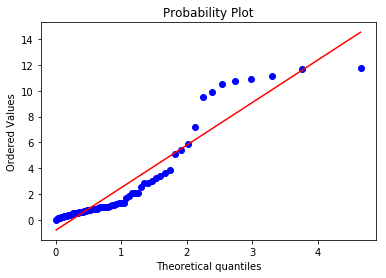



k = 3, size = 6
Number of positive jump times: 59
Mean: 1.717237288135593


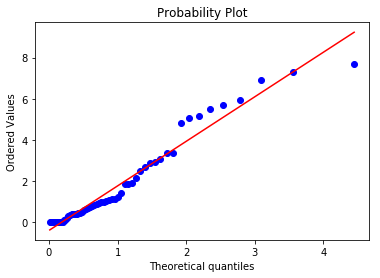



k = 3, size = 7
Number of positive jump times: 26
Mean: 1.6316153846153845


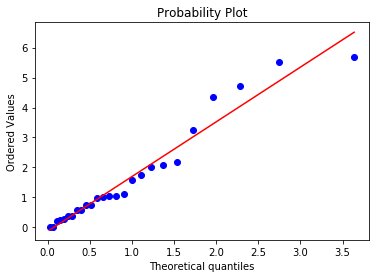



k = 3, size = 8
Number of positive jump times: 43
Mean: 0.747953488372093


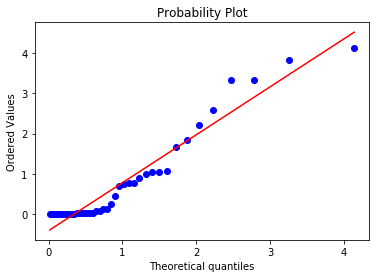



k = 4, size = 0
Number of positive jump times: 499
Mean: 2.6572224448897797


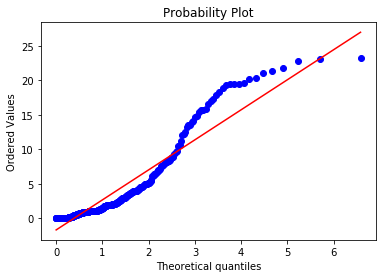



k = 4, size = 1
Number of positive jump times: 214
Mean: 1.4477757009345797


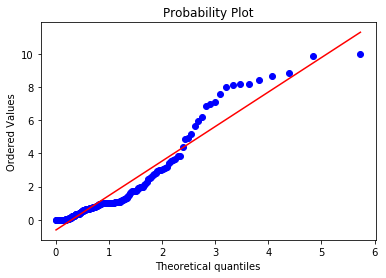



k = 4, size = 2
Number of positive jump times: 214
Mean: 0.8681915887850468


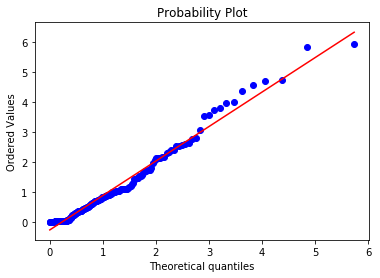



k = 4, size = 3
Number of positive jump times: 224
Mean: 0.35154910714285714


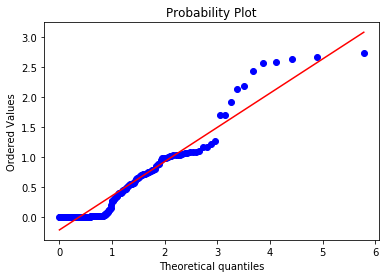



k = 4, size = 4
Number of positive jump times: 127
Mean: 0.4915196850393701


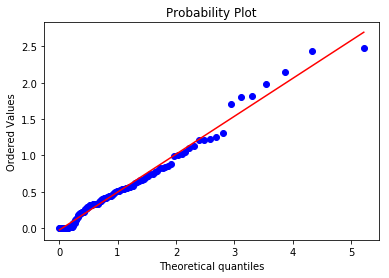



k = 4, size = 5
Number of positive jump times: 80
Mean: 1.035375


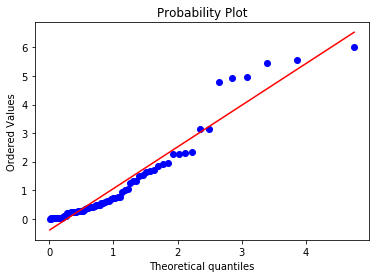



k = 4, size = 6
Number of positive jump times: 40
Mean: 2.26815


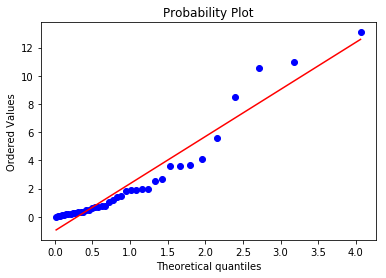



k = 4, size = 7
Number of positive jump times: 38
Mean: 0.5357631578947369


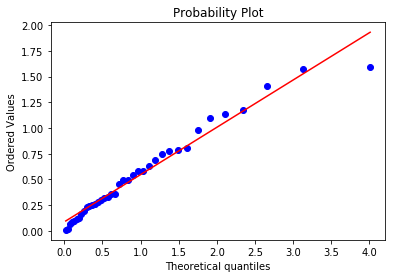



k = 4, size = 14
Number of positive jump times: 41
Mean: 3.759439024390244


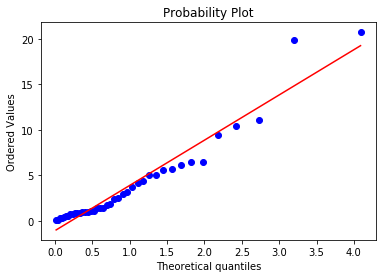



k = 4, size = 17
Number of positive jump times: 21
Mean: 1.8134285714285714


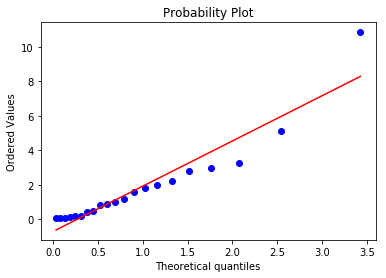



k = 4, size = 18
Number of positive jump times: 25
Mean: 2.19912


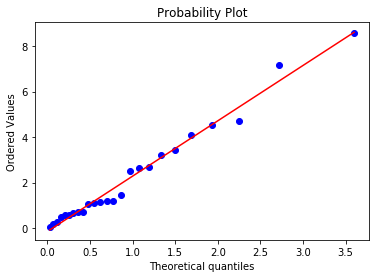



k = 5, size = 0
Number of positive jump times: 356
Mean: 7.820634755617976


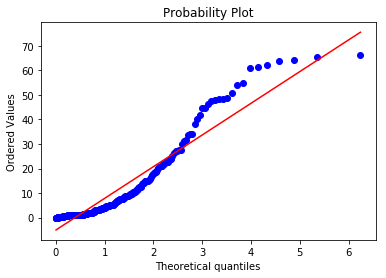



k = 5, size = 1
Number of positive jump times: 159
Mean: 1.7039308176100627


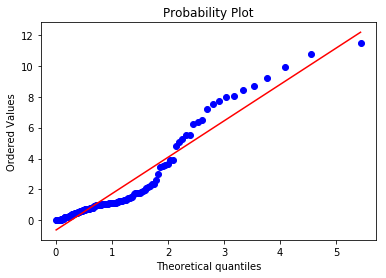



k = 5, size = 2
Number of positive jump times: 111
Mean: 1.892261261261261


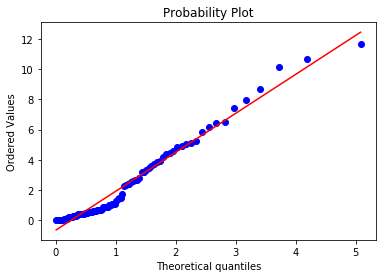



k = 5, size = 3
Number of positive jump times: 106
Mean: 1.189122641509434


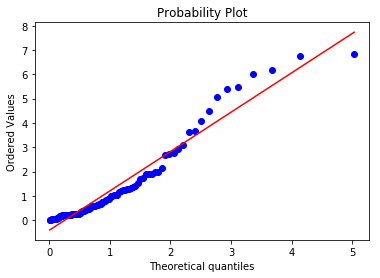



k = 5, size = 4
Number of positive jump times: 74
Mean: 1.9708918918918918


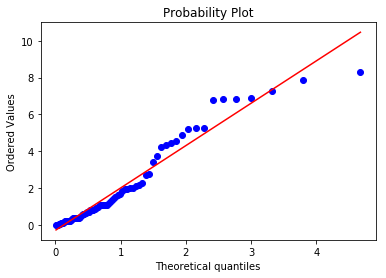



k = 6, size = 0
Number of positive jump times: 249
Mean: 24.425859437751004


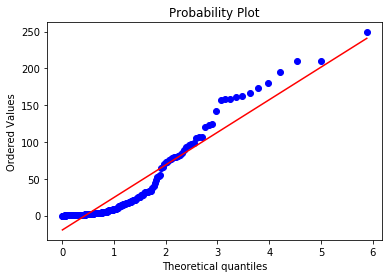



k = 6, size = 1
Number of positive jump times: 76
Mean: 0.48168421052631577


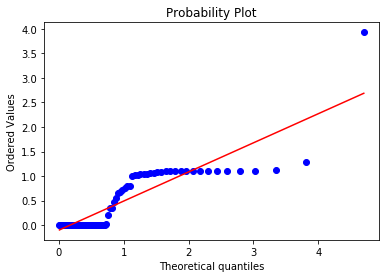



k = 6, size = 2
Number of positive jump times: 52
Mean: 3.1498653846153855


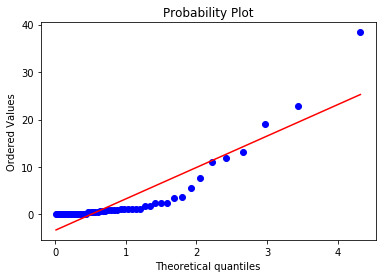



k = 6, size = 3
Number of positive jump times: 23
Mean: 23.508869565217395


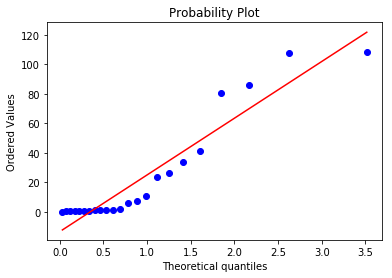



k = 6, size = 10
Number of positive jump times: 45
Mean: 0.30711111111111106


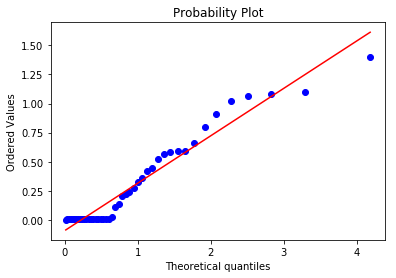



k = 6, size = 11
Number of positive jump times: 35
Mean: 0.3116571428571429


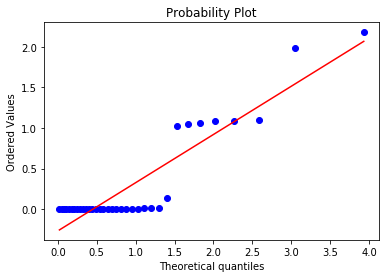



k = 6, size = 12
Number of positive jump times: 22
Mean: 0.7649999999999999


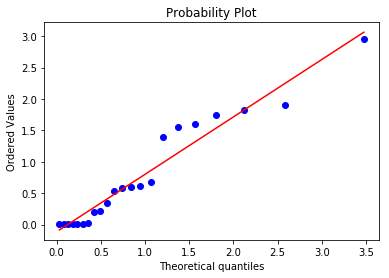



k = 6, size = 17
Number of positive jump times: 31
Mean: 5.826677419354839


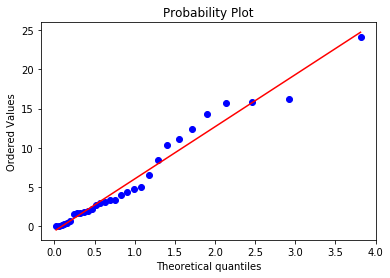



k = 6, size = 20
Number of positive jump times: 27
Mean: 4.217185185185186


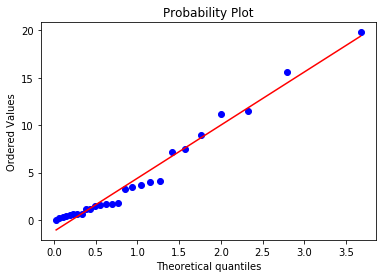



k = 7, size = 0
Number of positive jump times: 187
Mean: 33.46829946524064


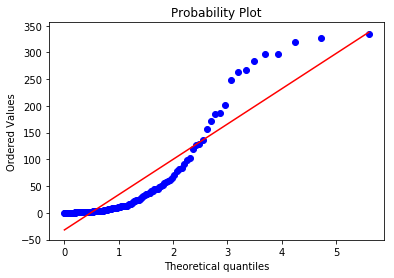



k = 7, size = 1
Number of positive jump times: 101
Mean: 1.4876930693069308


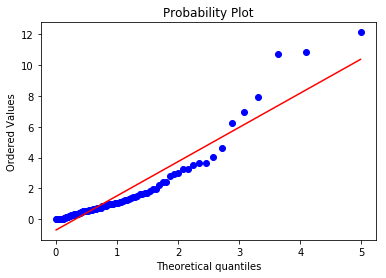



k = 7, size = 2
Number of positive jump times: 52
Mean: 0.11601923076923078


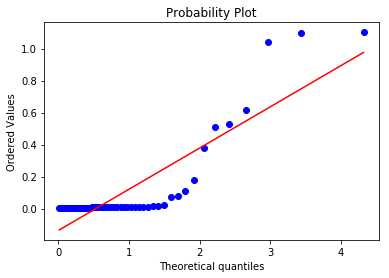



k = 8, size = 0
Number of positive jump times: 149
Mean: 79.62946308724831


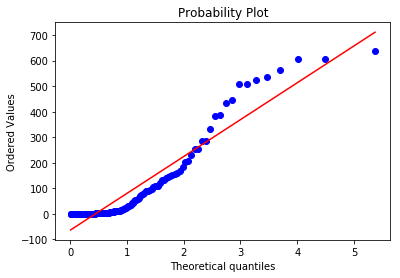



k = 8, size = 1
Number of positive jump times: 38
Mean: 0.5551315789473684


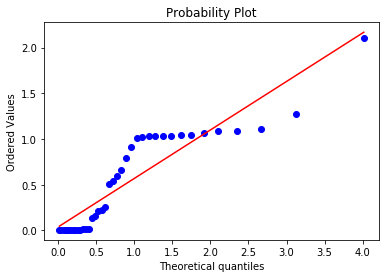



k = 8, size = 2
Number of positive jump times: 53
Mean: 2.012132075471698


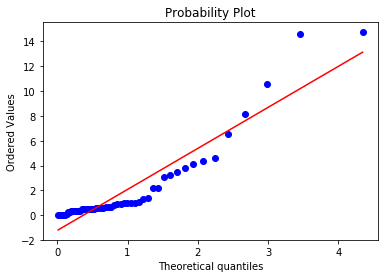



k = 8, size = 5
Number of positive jump times: 31
Mean: 1.2281935483870967


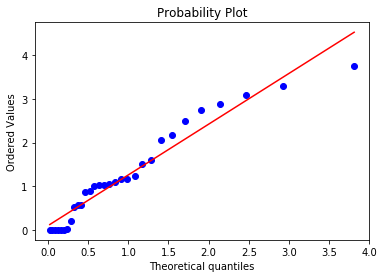



k = 8, size = 17
Number of positive jump times: 24
Mean: 0.36199999999999993


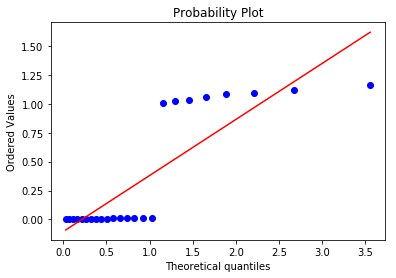



k = 9, size = 0
Number of positive jump times: 134
Mean: 38.68974626865671


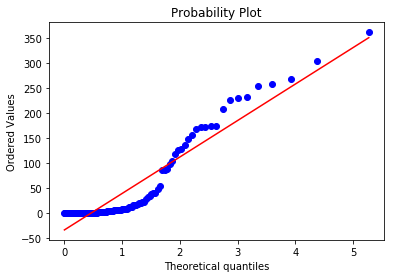



k = 9, size = 1
Number of positive jump times: 38
Mean: 1.1840263157894737


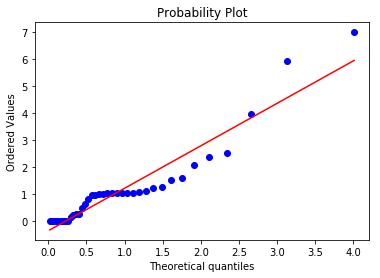



k = 10, size = 0
Number of positive jump times: 72
Mean: 285.47762500000005


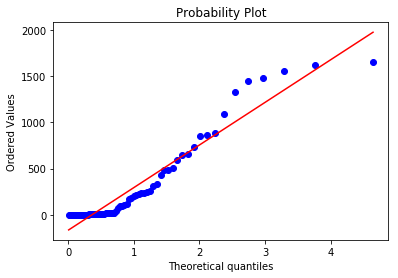



k = 10, size = 1
Number of positive jump times: 29
Mean: 1.1372758620689656


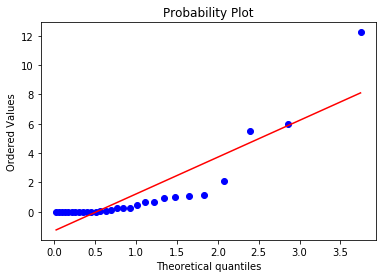



k = 10, size = 2
Number of positive jump times: 24
Mean: 243.55354166666666


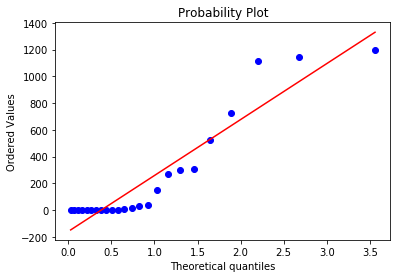



k = -10, size = 1
Number of negative jump times: 404
Mean: 1.0510841584158415


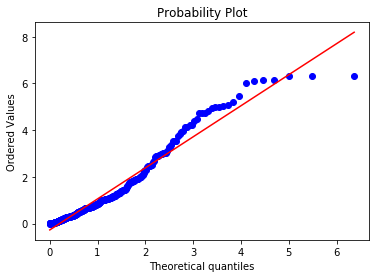



k = -10, size = 2
Number of negative jump times: 209
Mean: 2.376976076555024


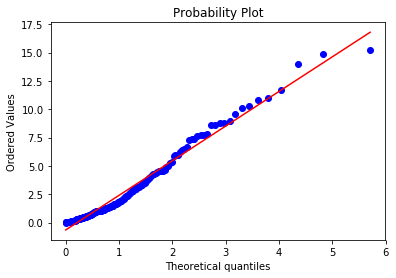



k = -10, size = 3
Number of negative jump times: 132
Mean: 1.992143939393939


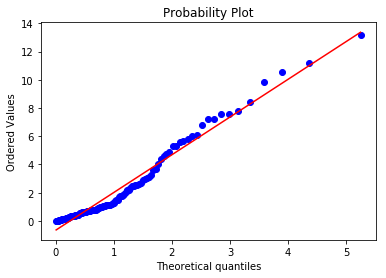



k = -10, size = 4
Number of negative jump times: 157
Mean: 2.8260191082802546


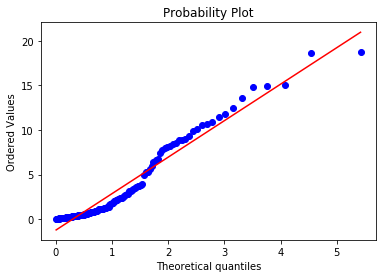



k = -10, size = 5
Number of negative jump times: 124
Mean: 1.9239193548387095


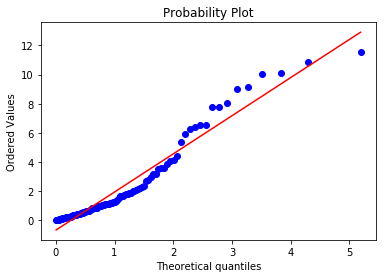



k = -10, size = 6
Number of negative jump times: 84
Mean: 2.772190476190476


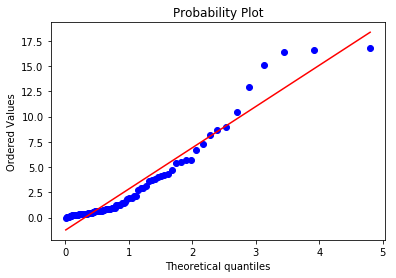



k = -10, size = 7
Number of negative jump times: 92
Mean: 2.4242717391304347


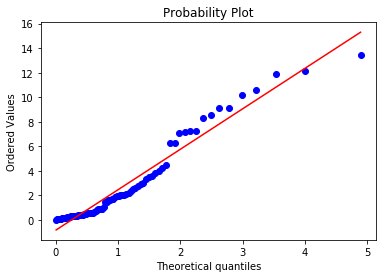



k = -10, size = 8
Number of negative jump times: 85
Mean: 1.8792352941176471


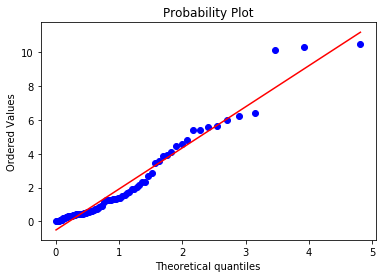



k = -10, size = 9
Number of negative jump times: 98
Mean: 2.0827448979591834


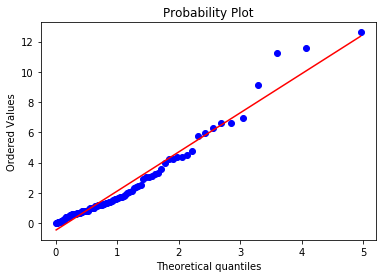



k = -10, size = 10
Number of negative jump times: 44
Mean: 1.5960227272727268


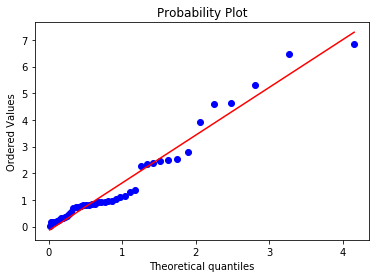



k = -10, size = 11
Number of negative jump times: 35
Mean: 1.8266571428571428


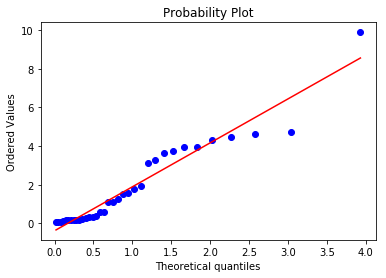



k = -10, size = 12
Number of negative jump times: 43
Mean: 2.152581395348837


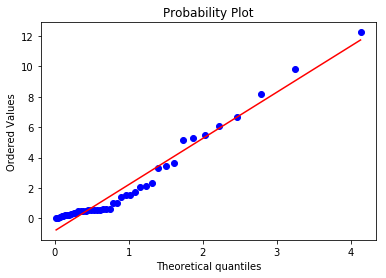



k = -10, size = 23
Number of negative jump times: 33
Mean: 8.757333333333332


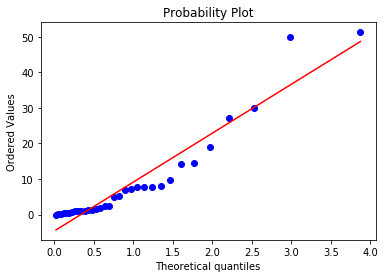



k = -10, size = 25
Number of negative jump times: 107
Mean: 4.702607476635514


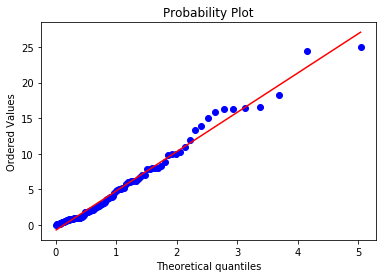



k = -10, size = 27
Number of negative jump times: 29
Mean: 6.481551724137931


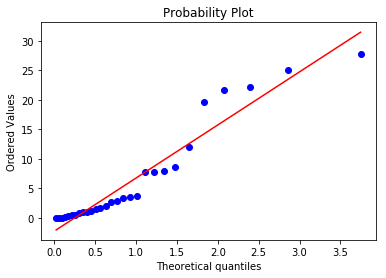



k = -10, size = 28
Number of negative jump times: 35
Mean: 3.931314285714286


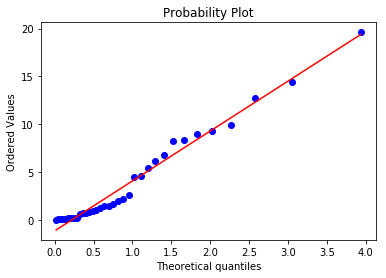



k = -10, size = 30
Number of negative jump times: 37
Mean: 2.688243243243243


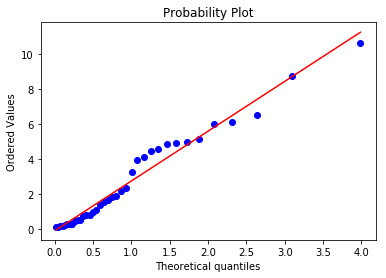



k = -10, size = 32
Number of negative jump times: 42
Mean: 3.8869999999999996


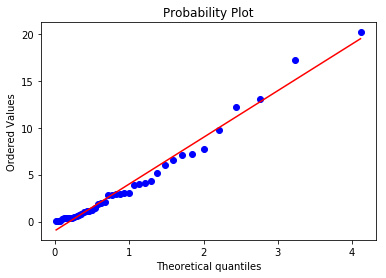



k = -9, size = 1
Number of negative jump times: 455
Mean: 1.0169604395604395


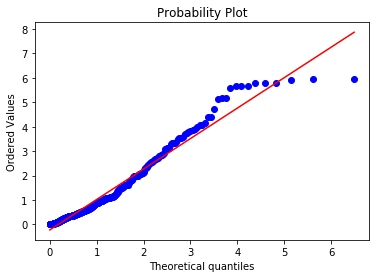



k = -9, size = 2
Number of negative jump times: 193
Mean: 2.217139896373057


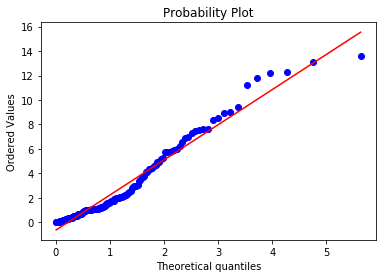



k = -9, size = 3
Number of negative jump times: 204
Mean: 1.5817549019607844


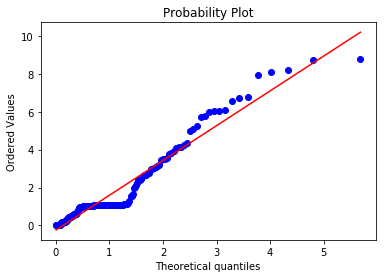



k = -9, size = 4
Number of negative jump times: 151
Mean: 2.223529801324503


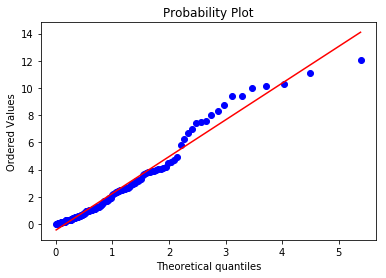



k = -9, size = 5
Number of negative jump times: 108
Mean: 1.3848796296296297


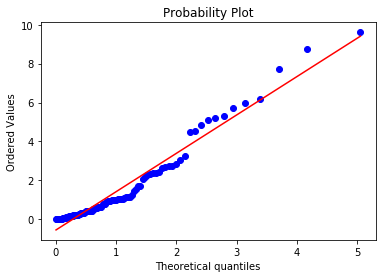



k = -9, size = 6
Number of negative jump times: 99
Mean: 1.7533636363636367


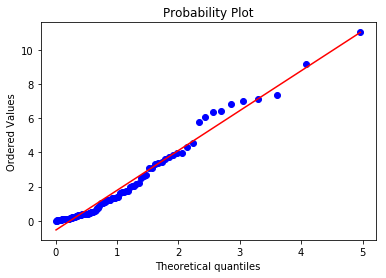



k = -9, size = 7
Number of negative jump times: 77
Mean: 1.0015584415584415


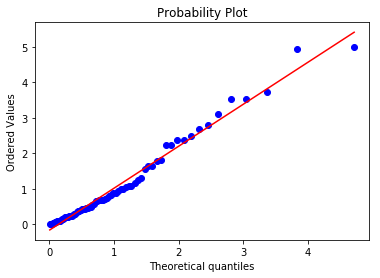



k = -9, size = 8
Number of negative jump times: 74
Mean: 1.316527027027027


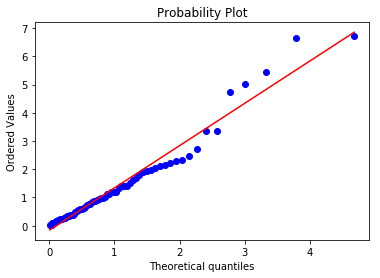



k = -9, size = 9
Number of negative jump times: 79
Mean: 1.788670886075949


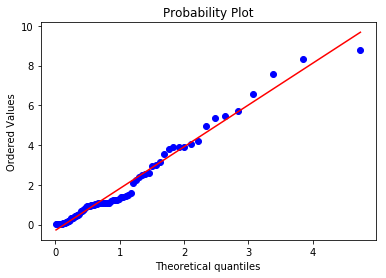



k = -9, size = 10
Number of negative jump times: 36
Mean: 2.4584166666666665


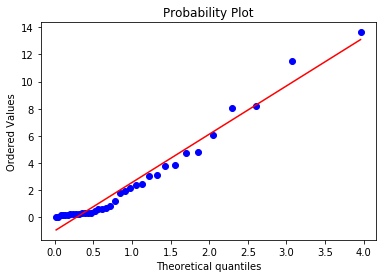



k = -9, size = 11
Number of negative jump times: 25
Mean: 2.11136


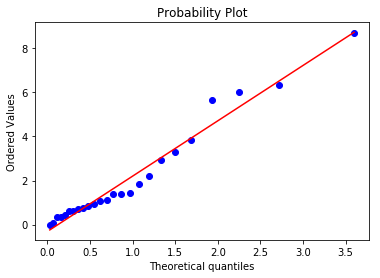



k = -9, size = 25
Number of negative jump times: 43
Mean: 5.393604651162791


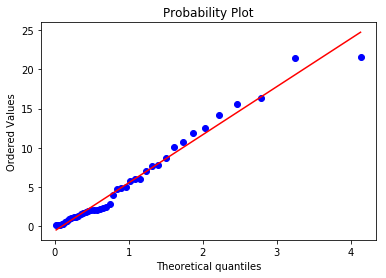



k = -9, size = 26
Number of negative jump times: 41
Mean: 3.492707317073171


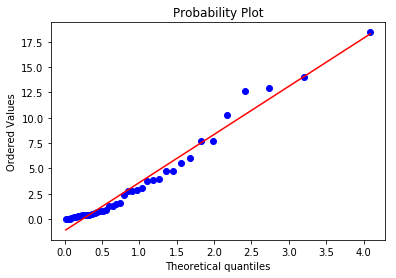



k = -9, size = 27
Number of negative jump times: 21
Mean: 0.5113333333333333


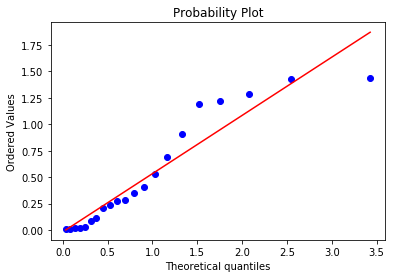



k = -9, size = 28
Number of negative jump times: 67
Mean: 1.9264029850746271


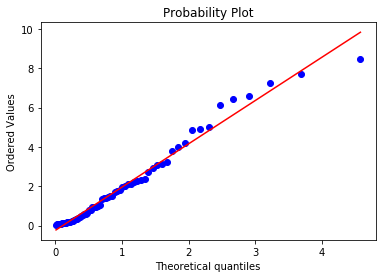



k = -9, size = 29
Number of negative jump times: 45
Mean: 1.3552666666666666


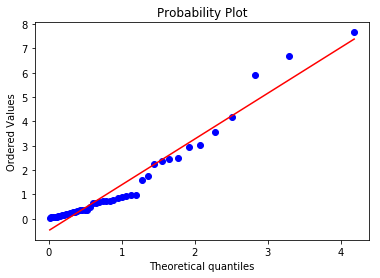



k = -9, size = 30
Number of negative jump times: 38
Mean: 3.6834210526315787


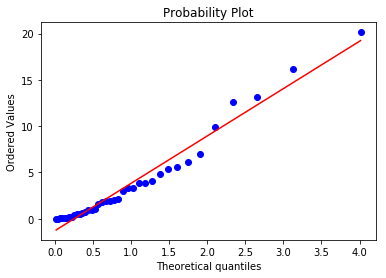



k = -9, size = 31
Number of negative jump times: 33
Mean: 5.123666666666666


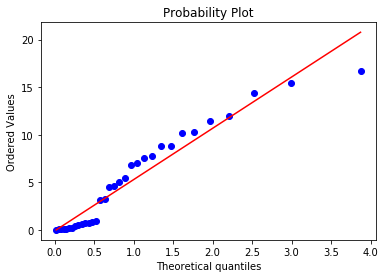



k = -8, size = 1
Number of negative jump times: 289
Mean: 0.94960553633218


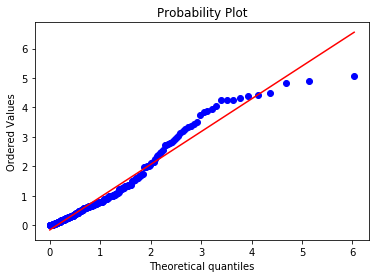



k = -8, size = 2
Number of negative jump times: 179
Mean: 1.553033519553073


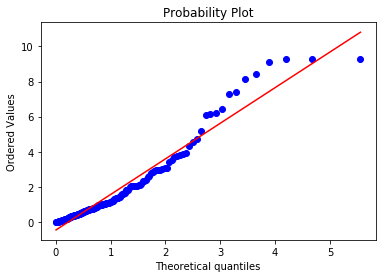



k = -8, size = 3
Number of negative jump times: 87
Mean: 2.348528735632184


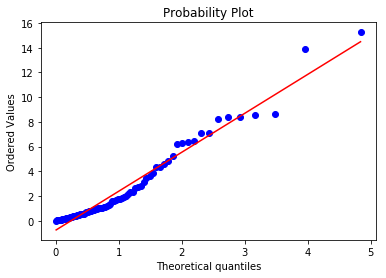



k = -8, size = 4
Number of negative jump times: 109
Mean: 1.6751192660550462


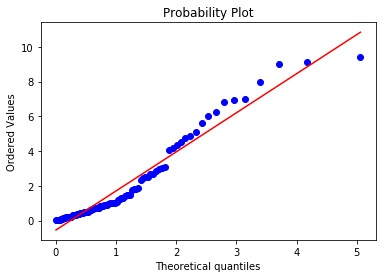



k = -8, size = 5
Number of negative jump times: 71
Mean: 2.237647887323944


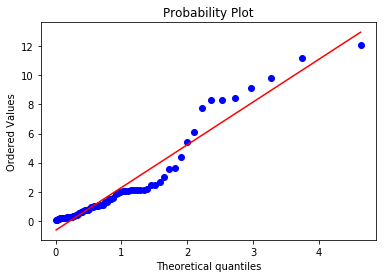



k = -8, size = 6
Number of negative jump times: 63
Mean: 3.0149523809523813


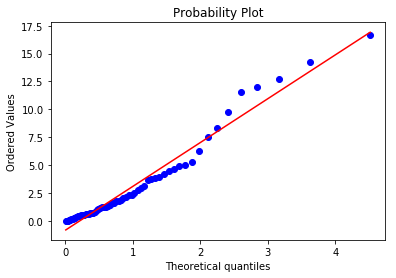



k = -8, size = 7
Number of negative jump times: 67
Mean: 1.5615820895522388


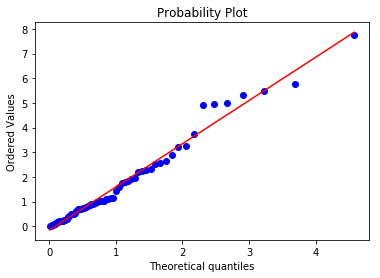



k = -8, size = 8
Number of negative jump times: 47
Mean: 2.3670425531914896


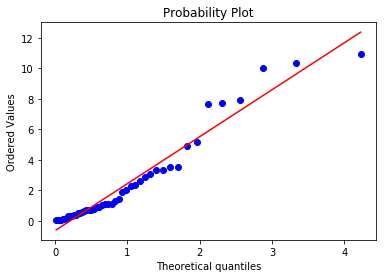



k = -8, size = 9
Number of negative jump times: 55
Mean: 0.9258727272727274


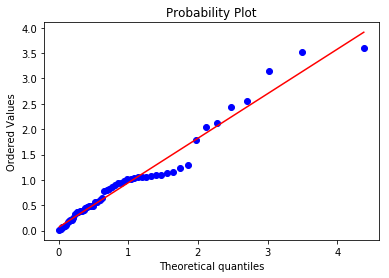



k = -8, size = 10
Number of negative jump times: 46
Mean: 1.3910217391304347


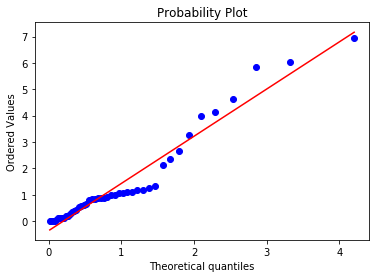



k = -8, size = 11
Number of negative jump times: 38
Mean: 1.1582894736842104


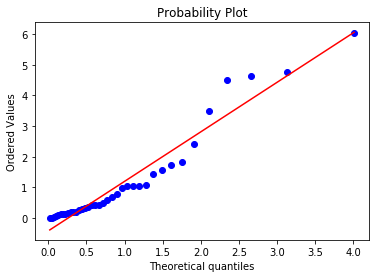



k = -8, size = 12
Number of negative jump times: 33
Mean: 0.9243636363636363


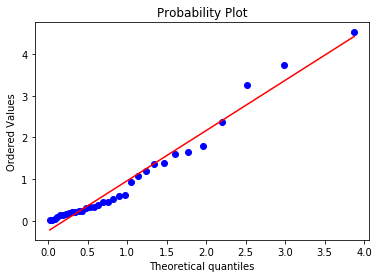



k = -8, size = 13
Number of negative jump times: 21
Mean: 1.0852857142857144


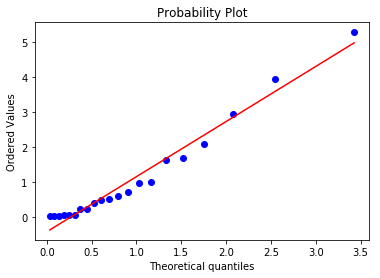



k = -8, size = 25
Number of negative jump times: 49
Mean: 3.4643469387755097


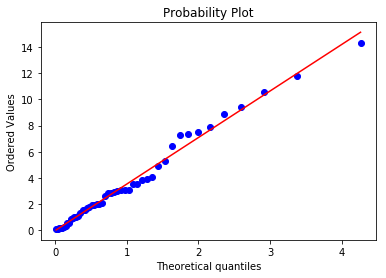



k = -8, size = 26
Number of negative jump times: 28
Mean: 3.5434285714285716


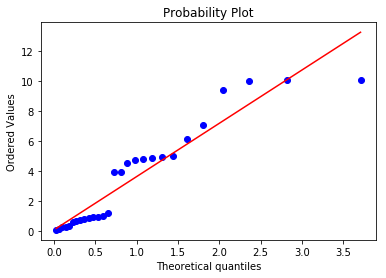



k = -8, size = 27
Number of negative jump times: 67
Mean: 3.575970149253731


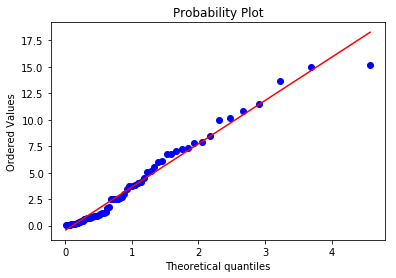



k = -8, size = 29
Number of negative jump times: 30
Mean: 1.7817666666666667


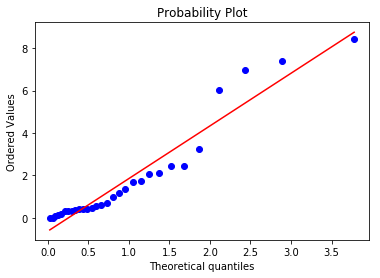



k = -7, size = 1
Number of negative jump times: 206
Mean: 1.5287038834951456


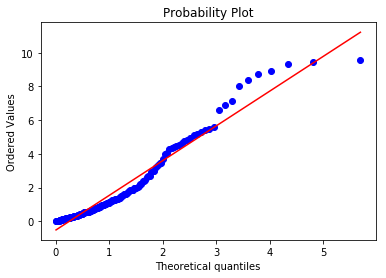



k = -7, size = 2
Number of negative jump times: 185
Mean: 1.5005675675675676


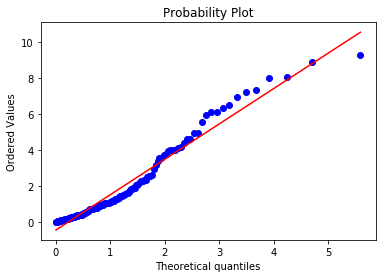



k = -7, size = 3
Number of negative jump times: 221
Mean: 2.581877828054299


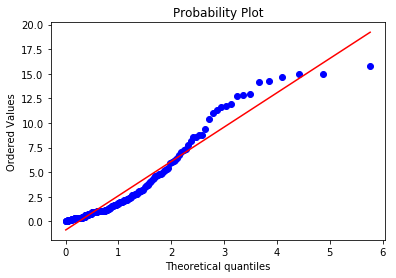



k = -7, size = 4
Number of negative jump times: 125
Mean: 1.568072


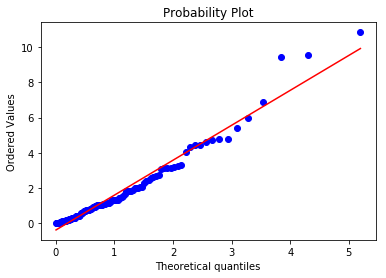



k = -7, size = 5
Number of negative jump times: 145
Mean: 1.6303241379310343


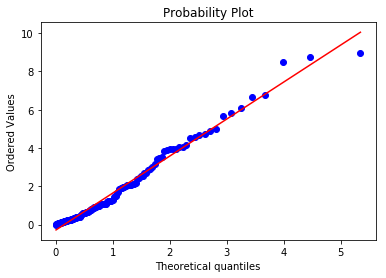



k = -7, size = 6
Number of negative jump times: 74
Mean: 1.1554054054054055


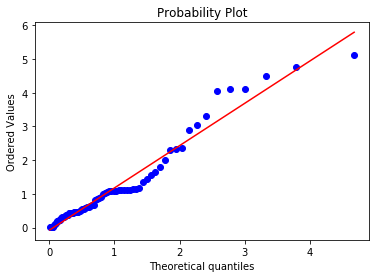



k = -7, size = 7
Number of negative jump times: 56
Mean: 1.3890714285714287


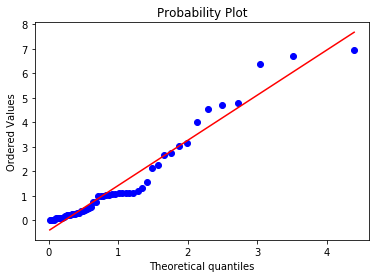



k = -7, size = 8
Number of negative jump times: 40
Mean: 1.2593


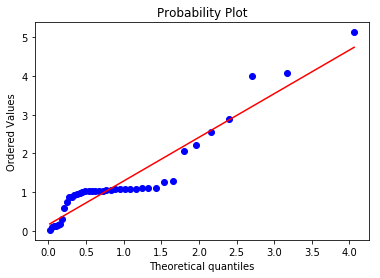



k = -7, size = 22
Number of negative jump times: 21
Mean: 2.883809523809524


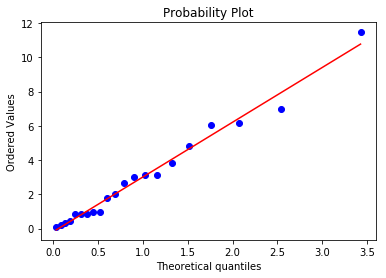



k = -7, size = 23
Number of negative jump times: 27
Mean: 4.463444444444445


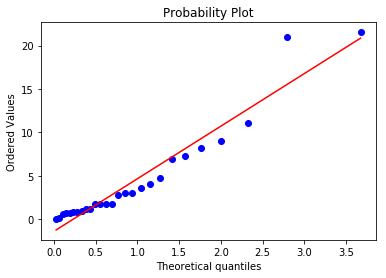



k = -7, size = 24
Number of negative jump times: 23
Mean: 4.115173913043479


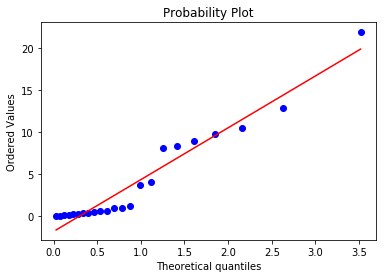



k = -7, size = 25
Number of negative jump times: 28
Mean: 2.9284642857142855


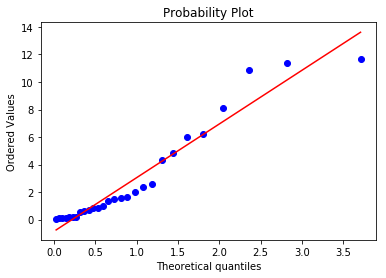



k = -7, size = 26
Number of negative jump times: 23
Mean: 0.38378260869565217


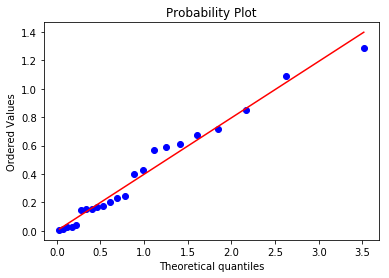



k = -6, size = 1
Number of negative jump times: 303
Mean: 0.8642508250825083


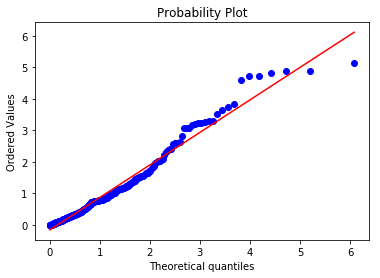



k = -6, size = 2
Number of negative jump times: 99
Mean: 2.8698282828282826


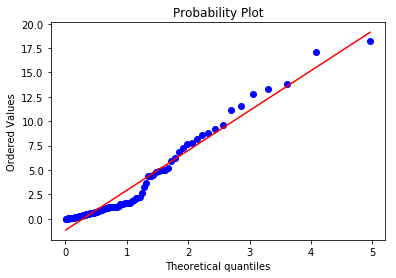



k = -6, size = 3
Number of negative jump times: 75
Mean: 1.6470133333333334


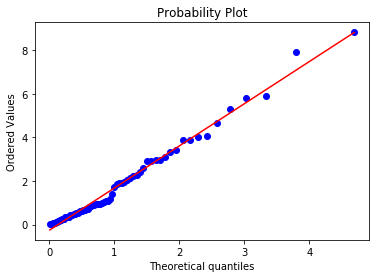



k = -6, size = 4
Number of negative jump times: 87
Mean: 2.834068965517241


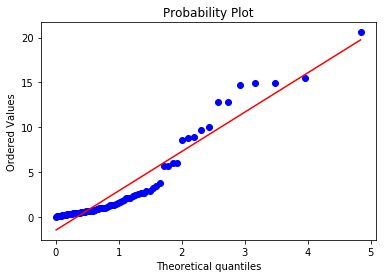



k = -6, size = 5
Number of negative jump times: 59
Mean: 1.6142881355932202


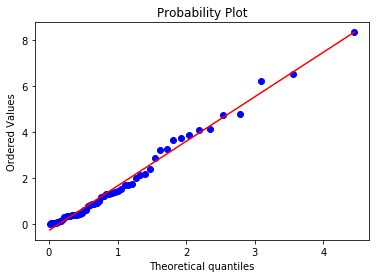



k = -6, size = 6
Number of negative jump times: 41
Mean: 2.3503414634146345


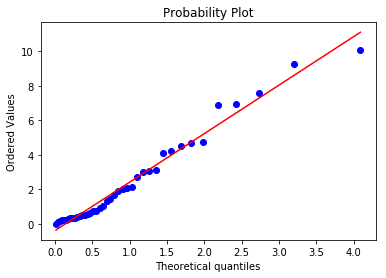



k = -6, size = 7
Number of negative jump times: 28
Mean: 1.7625714285714285


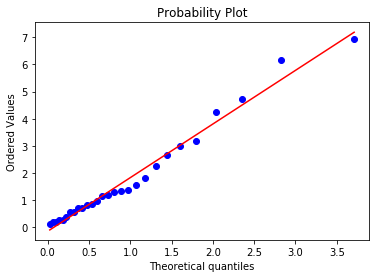



k = -6, size = 8
Number of negative jump times: 26
Mean: 1.6914615384615386


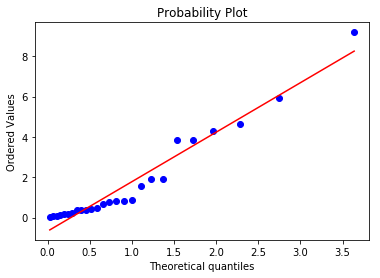



k = -6, size = 9
Number of negative jump times: 40
Mean: 2.668


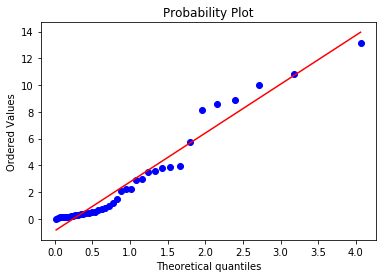



k = -6, size = 13
Number of negative jump times: 38
Mean: 2.6248421052631574


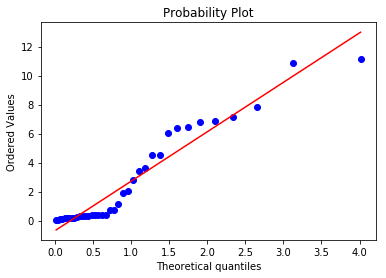



k = -6, size = 24
Number of negative jump times: 47
Mean: 3.7386808510638296


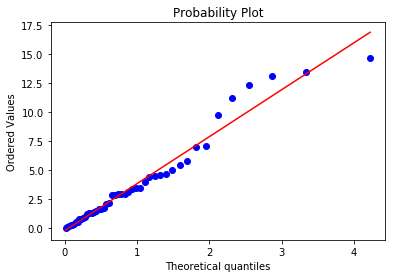



k = -6, size = 25
Number of negative jump times: 64
Mean: 3.080359375


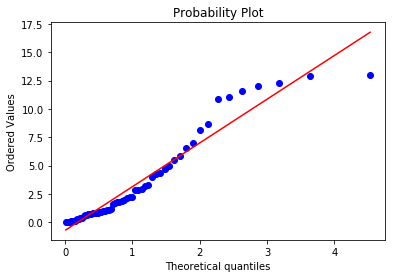



k = -6, size = 26
Number of negative jump times: 124
Mean: 4.740032258064516


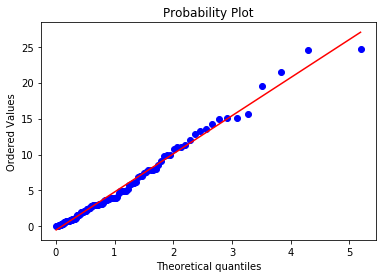



k = -5, size = 1
Number of negative jump times: 215
Mean: 3.0508418604651166


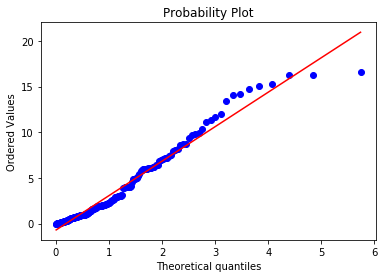



k = -5, size = 2
Number of negative jump times: 229
Mean: 2.8296113537117904


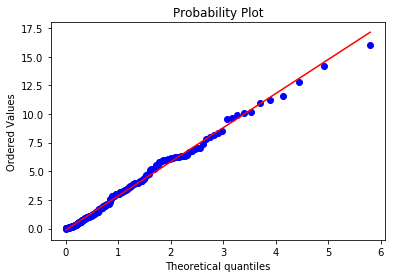



k = -5, size = 3
Number of negative jump times: 101
Mean: 3.367267326732674


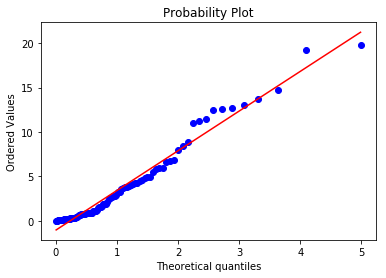



k = -5, size = 4
Number of negative jump times: 77
Mean: 4.384739909090909


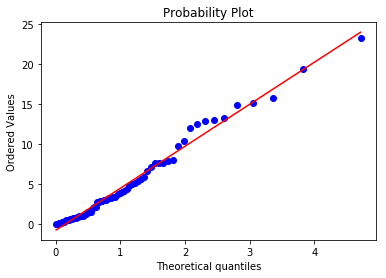



k = -5, size = 5
Number of negative jump times: 78
Mean: 0.9600641025641027


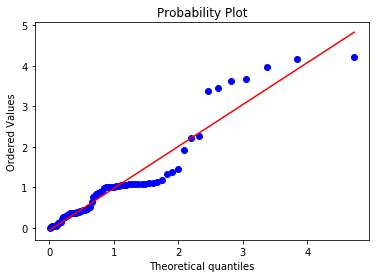



k = -5, size = 6
Number of negative jump times: 47
Mean: 5.010936170212766


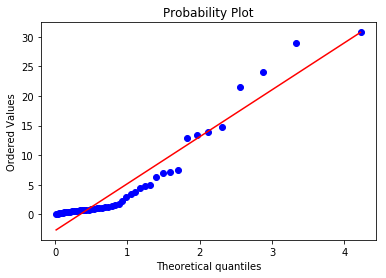



k = -5, size = 7
Number of negative jump times: 40
Mean: 1.323725


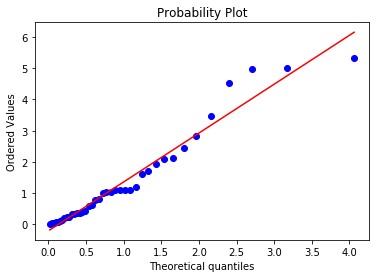



k = -5, size = 10
Number of negative jump times: 26
Mean: 4.82573076923077


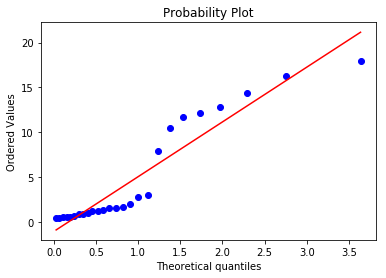



k = -5, size = 20
Number of negative jump times: 38
Mean: 5.083394736842106


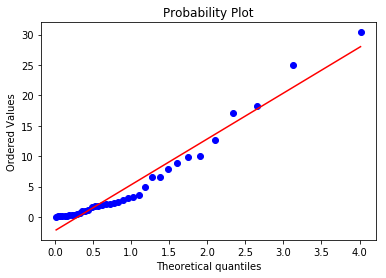



k = -5, size = 21
Number of negative jump times: 27
Mean: 3.3214814814814817


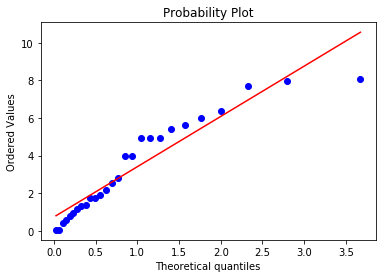



k = -5, size = 22
Number of negative jump times: 21
Mean: 9.510904761904763


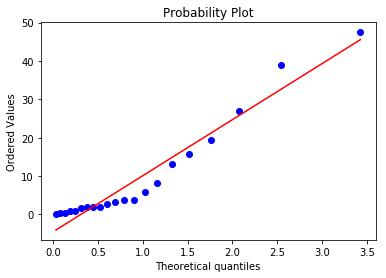



k = -4, size = 1
Number of negative jump times: 160
Mean: 1.376575


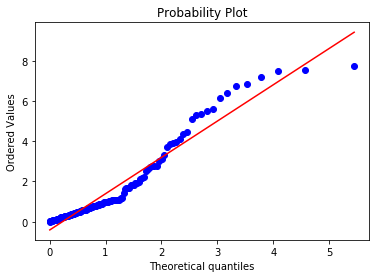



k = -4, size = 2
Number of negative jump times: 70
Mean: 1.4690142857142856


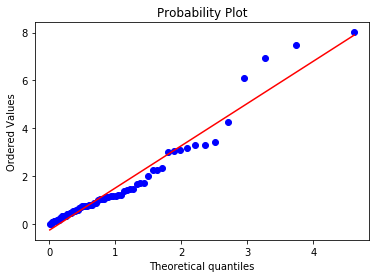



k = -4, size = 3
Number of negative jump times: 125
Mean: 2.562464


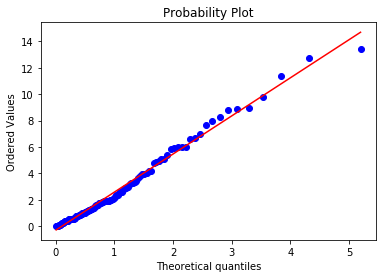



k = -4, size = 4
Number of negative jump times: 63
Mean: 2.587825396825397


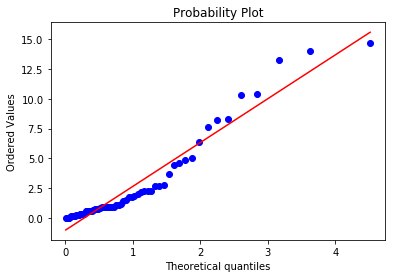



k = -4, size = 5
Number of negative jump times: 40
Mean: 1.167675


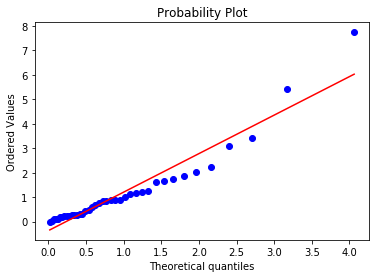



k = -4, size = 6
Number of negative jump times: 42
Mean: 1.661690476190476


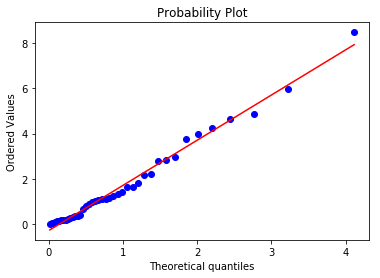



k = -4, size = 7
Number of negative jump times: 31
Mean: 1.8705483870967743


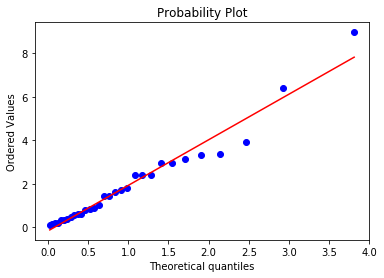



k = -4, size = 19
Number of negative jump times: 282
Mean: 4.163528368794326


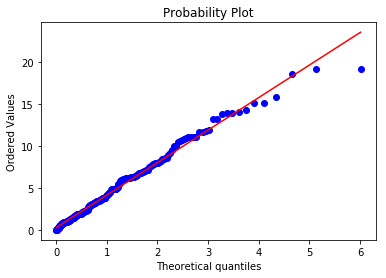



k = -4, size = 20
Number of negative jump times: 25
Mean: 1.7226400000000002


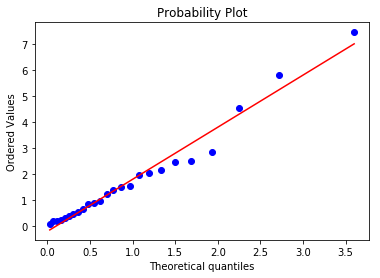



k = -4, size = 21
Number of negative jump times: 52
Mean: 2.283423076923077


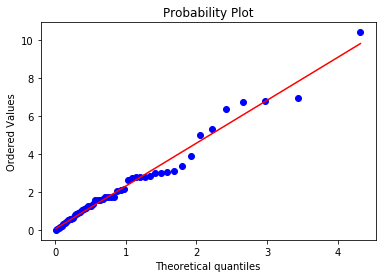



k = -4, size = 22
Number of negative jump times: 22
Mean: 1.6866818181818182


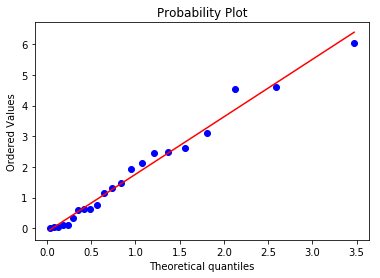



k = -4, size = 23
Number of negative jump times: 33
Mean: 4.0030909090909095


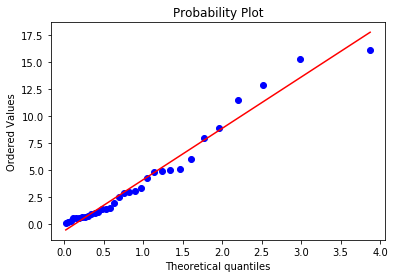



k = -4, size = 24
Number of negative jump times: 21
Mean: 1.7447619047619047


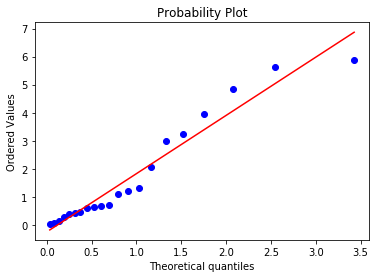



k = -3, size = 1
Number of negative jump times: 190
Mean: 2.7628631578947367


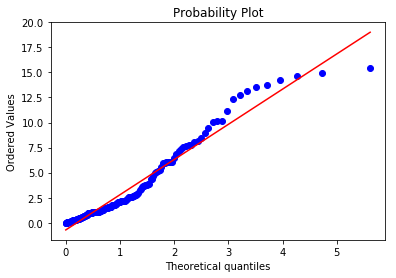



k = -3, size = 2
Number of negative jump times: 210
Mean: 2.3693


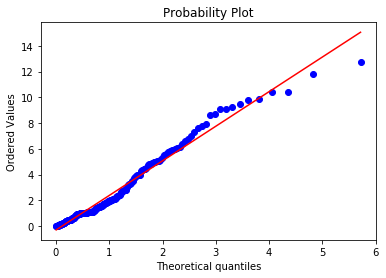



k = -3, size = 3
Number of negative jump times: 107
Mean: 1.4072056074766355


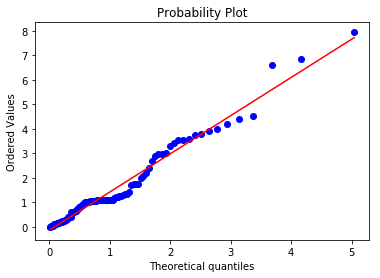



k = -3, size = 4
Number of negative jump times: 74
Mean: 1.253216216216216


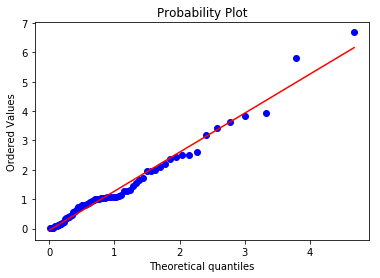



k = -3, size = 5
Number of negative jump times: 67
Mean: 0.7916119402985075


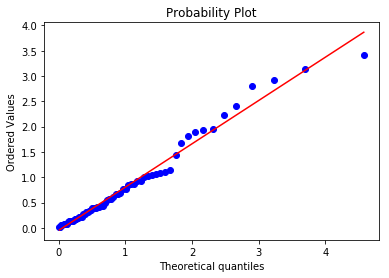



k = -3, size = 6
Number of negative jump times: 70
Mean: 1.1529714285714288


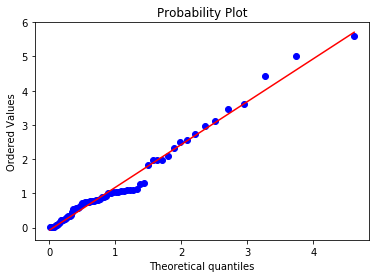



k = -3, size = 7
Number of negative jump times: 65
Mean: 1.075476923076923


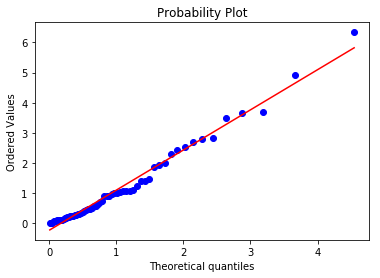



k = -3, size = 8
Number of negative jump times: 50
Mean: 2.3402800000000004


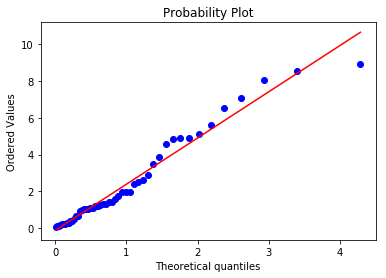



k = -3, size = 9
Number of negative jump times: 24
Mean: 1.3044166666666666


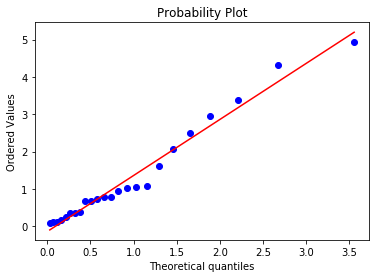



k = -3, size = 10
Number of negative jump times: 29
Mean: 0.542


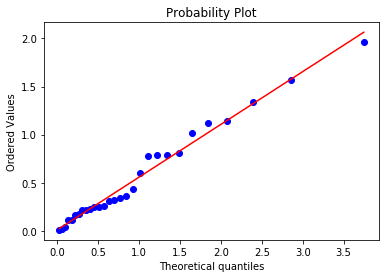



k = -3, size = 11
Number of negative jump times: 22
Mean: 0.6158636363636364


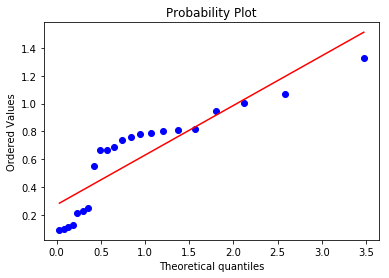



k = -3, size = 20
Number of negative jump times: 35
Mean: 3.596828571428572


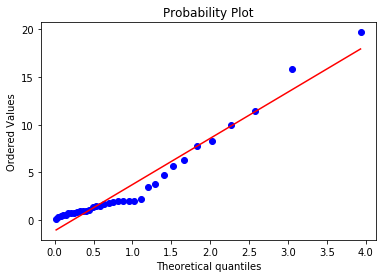



k = -3, size = 22
Number of negative jump times: 169
Mean: 5.138497041420118


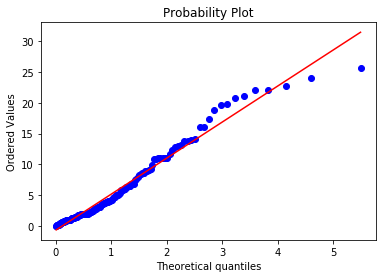



k = -3, size = 23
Number of negative jump times: 26
Mean: 3.4896923076923083


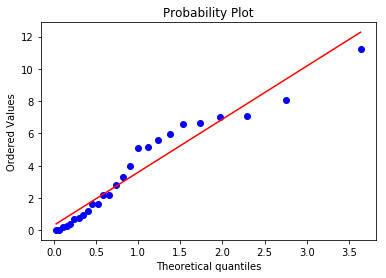



k = -3, size = 25
Number of negative jump times: 30
Mean: 4.346233333333333


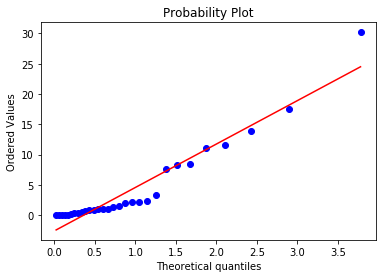



k = -3, size = 26
Number of negative jump times: 50
Mean: 1.30124


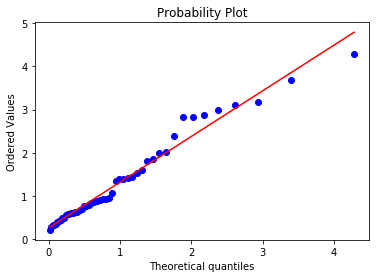



k = -2, size = 1
Number of negative jump times: 166
Mean: 1.2837048192771083


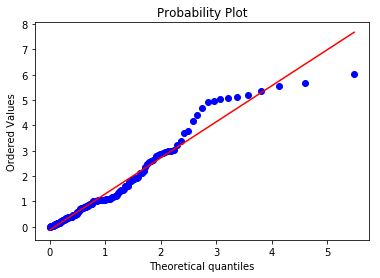



k = -2, size = 2
Number of negative jump times: 106
Mean: 1.005311320754717


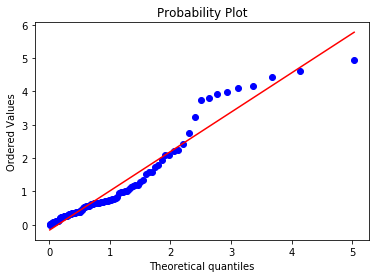



k = -2, size = 3
Number of negative jump times: 163
Mean: 2.3699999999999997


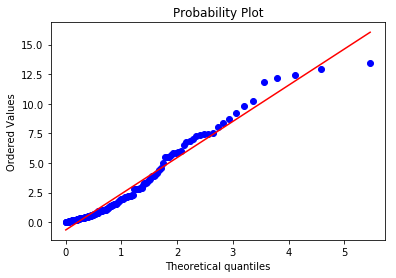



k = -2, size = 4
Number of negative jump times: 145
Mean: 1.9308275862068967


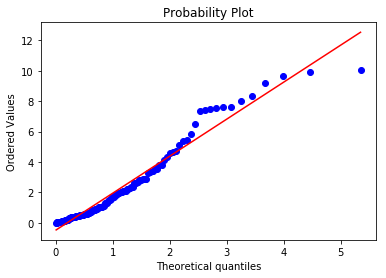



k = -2, size = 5
Number of negative jump times: 112
Mean: 1.1005714285714283


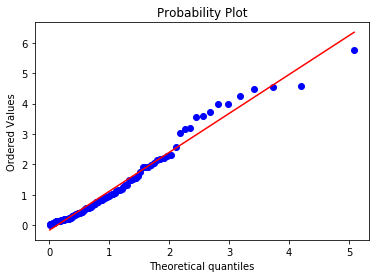



k = -2, size = 6
Number of negative jump times: 87
Mean: 1.0042988505747124


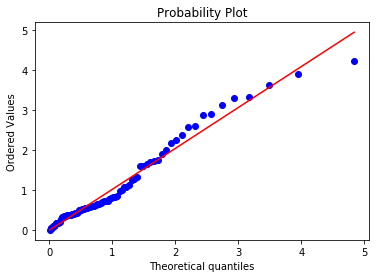



k = -2, size = 7
Number of negative jump times: 100
Mean: 1.18346


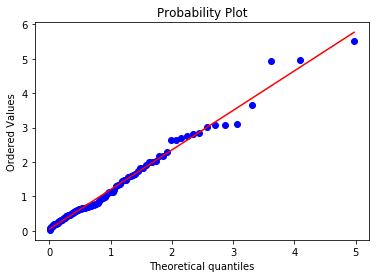



k = -2, size = 8
Number of negative jump times: 106
Mean: 0.8929716981132074


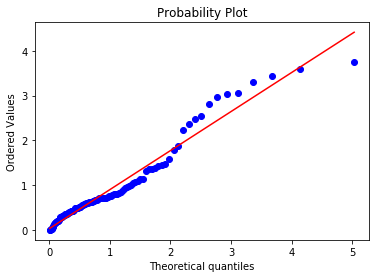



k = -2, size = 9
Number of negative jump times: 32
Mean: 1.06296875


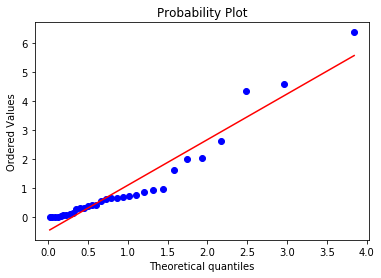



k = -2, size = 10
Number of negative jump times: 30
Mean: 1.6402333333333332


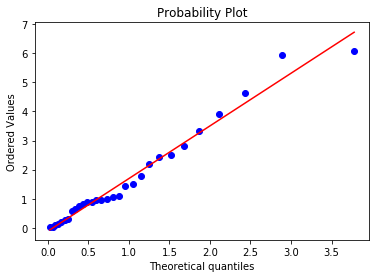



k = -2, size = 18
Number of negative jump times: 82
Mean: 3.52109756097561


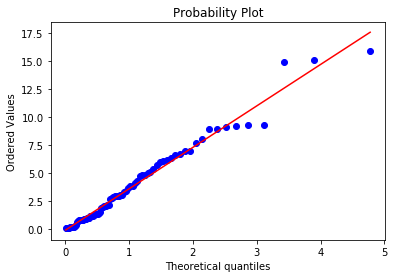



k = -2, size = 23
Number of negative jump times: 41
Mean: 4.682658536585366


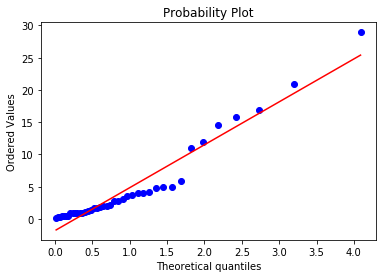



k = -1, size = 1
Number of negative jump times: 142
Mean: 1.809098591549296


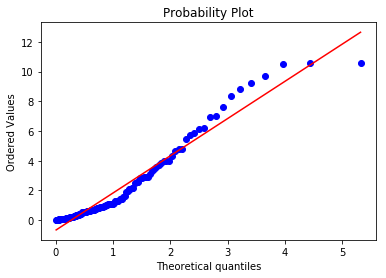



k = -1, size = 2
Number of negative jump times: 134
Mean: 1.8846194029850745


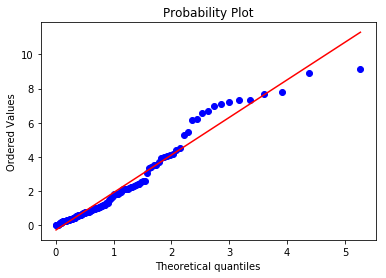



k = -1, size = 3
Number of negative jump times: 129
Mean: 3.1049999999999995


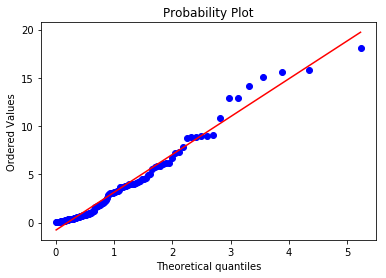



k = -1, size = 4
Number of negative jump times: 92
Mean: 2.972945652173913


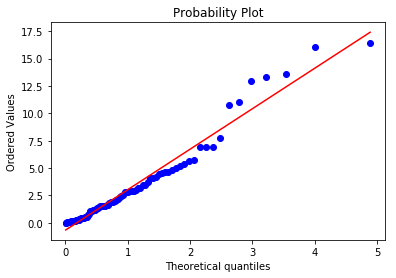



k = -1, size = 5
Number of negative jump times: 53
Mean: 2.3450188679245283


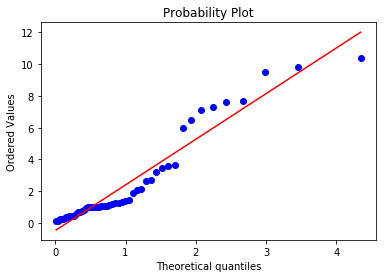



k = -1, size = 6
Number of negative jump times: 89
Mean: 1.315123595505618


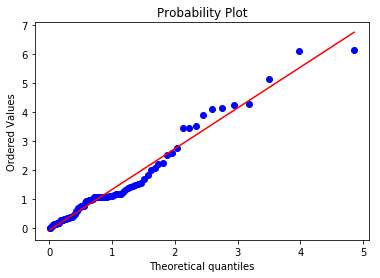



k = -1, size = 7
Number of negative jump times: 36
Mean: 3.6416388888888886


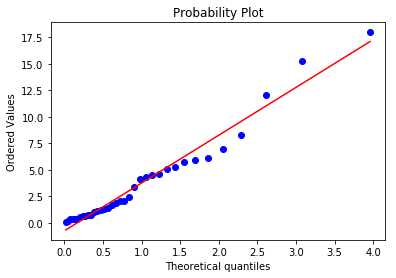



k = -1, size = 8
Number of negative jump times: 48
Mean: 5.611958333333334


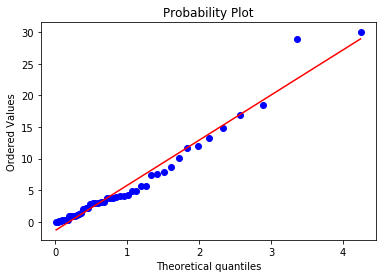



k = -1, size = 19
Number of negative jump times: 54
Mean: 2.4262962962962966


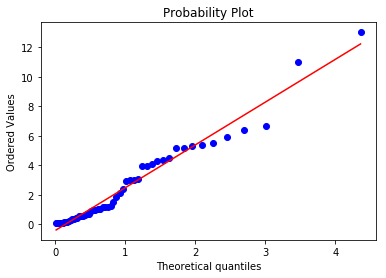



k = -1, size = 23
Number of negative jump times: 23
Mean: 2.107173913043478


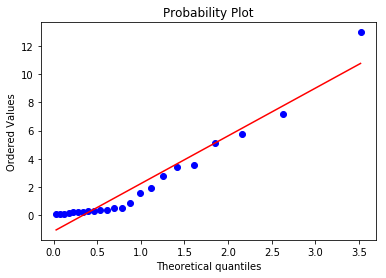



k = -1, size = 25
Number of negative jump times: 46
Mean: 1.107


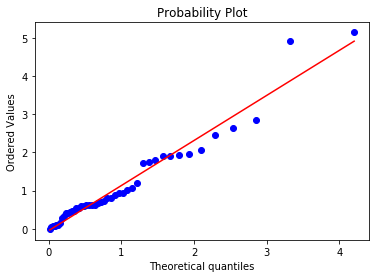



k = -1, size = 27
Number of negative jump times: 36
Mean: 0.9814444444444445


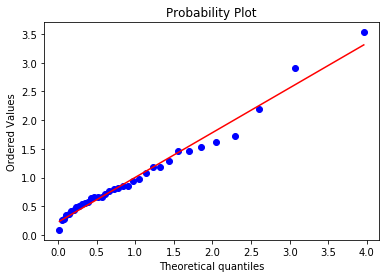



k = 1, size = 1
Number of negative jump times: 289
Mean: 0.9316124567474048


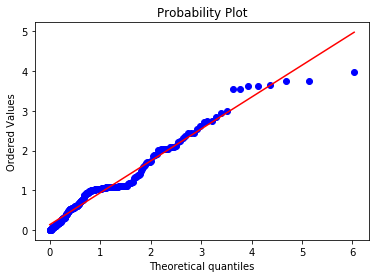



k = 1, size = 2
Number of negative jump times: 187
Mean: 1.3121176470588234


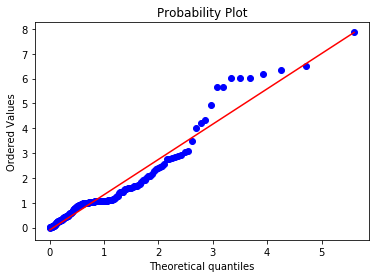



k = 1, size = 3
Number of negative jump times: 145
Mean: 1.2506274


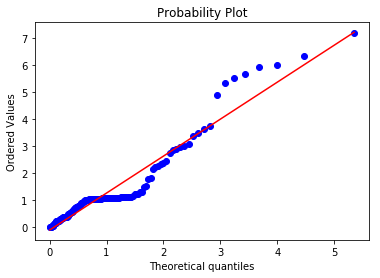



k = 1, size = 4
Number of negative jump times: 63
Mean: 1.3924126984126985


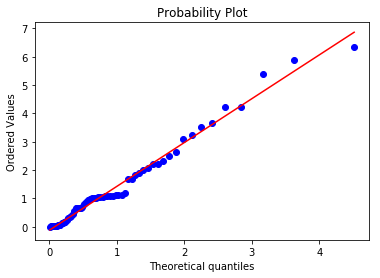



k = 1, size = 5
Number of negative jump times: 55
Mean: 0.9757636363636364


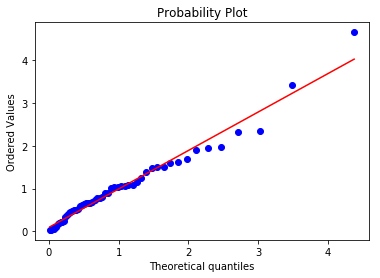



k = 1, size = 6
Number of negative jump times: 73
Mean: 1.1630000000000003


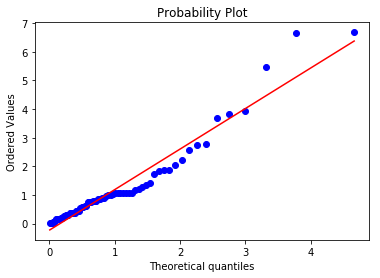



k = 1, size = 7
Number of negative jump times: 56
Mean: 1.2409107142857143


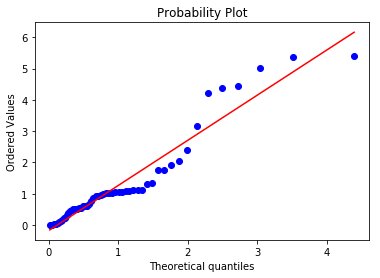



k = 1, size = 8
Number of negative jump times: 46
Mean: 3.341934782608696


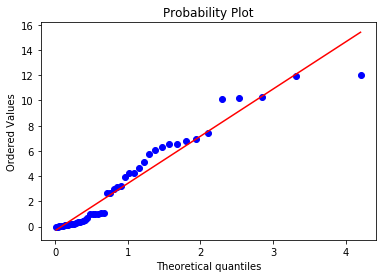



k = 1, size = 9
Number of negative jump times: 33
Mean: 2.59369696969697


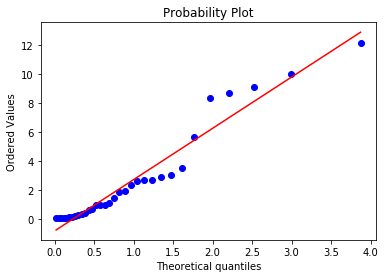



k = 1, size = 10
Number of negative jump times: 52
Mean: 2.268923076923077


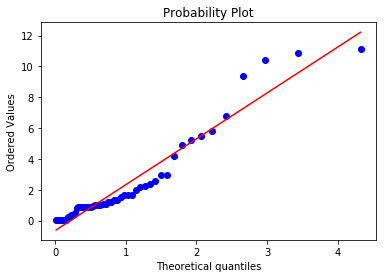



k = 2, size = 1
Number of negative jump times: 195
Mean: 1.1111641025641026


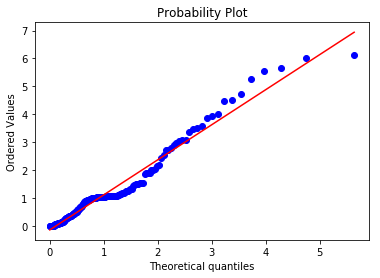



k = 2, size = 2
Number of negative jump times: 203
Mean: 1.789177339901478


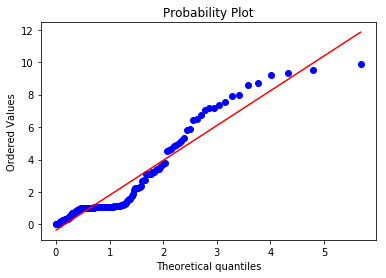



k = 2, size = 3
Number of negative jump times: 130
Mean: 2.4984384615384614


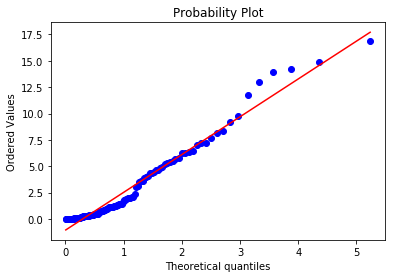



k = 2, size = 4
Number of negative jump times: 66
Mean: 1.8944393939393938


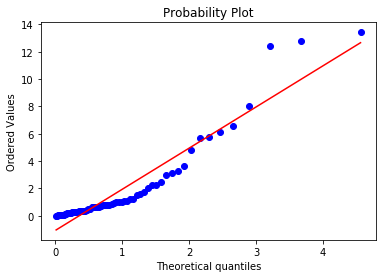



k = 2, size = 5
Number of negative jump times: 76
Mean: 1.228723684210526


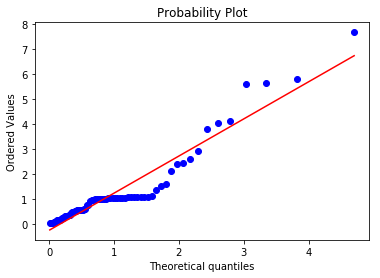



k = 2, size = 6
Number of negative jump times: 45
Mean: 2.9379555555555554


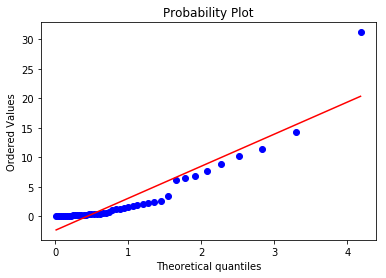



k = 2, size = 7
Number of negative jump times: 36
Mean: 2.067944444444444


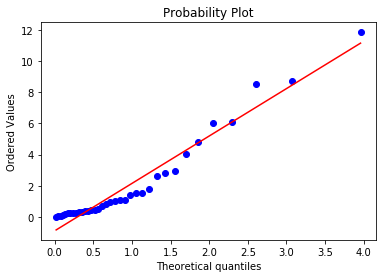



k = 2, size = 11
Number of negative jump times: 27
Mean: 1.572962962962963


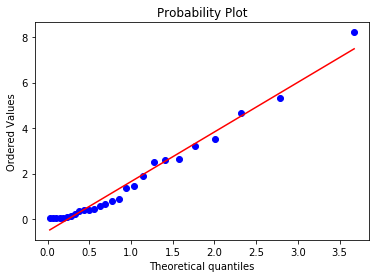



k = 3, size = 1
Number of negative jump times: 117
Mean: 1.6126666666666665


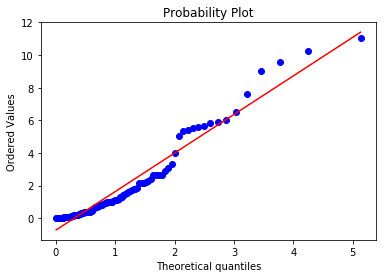



k = 3, size = 2
Number of negative jump times: 113
Mean: 1.0779734513274337


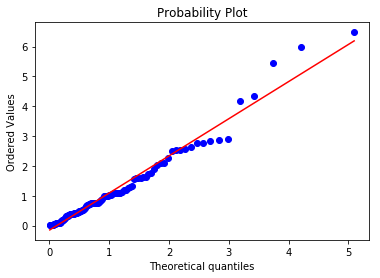



k = 3, size = 3
Number of negative jump times: 91
Mean: 1.232098901098901


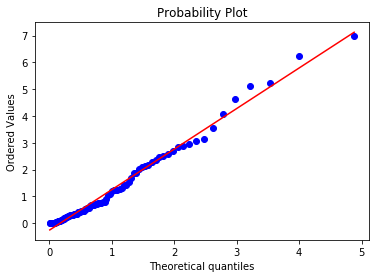



k = 3, size = 4
Number of negative jump times: 83
Mean: 1.1096987951807227


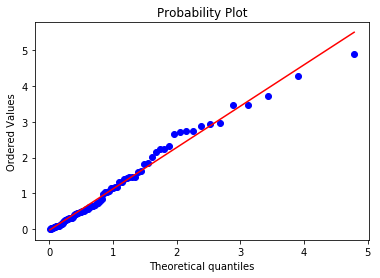



k = 3, size = 5
Number of negative jump times: 66
Mean: 1.652590909090909


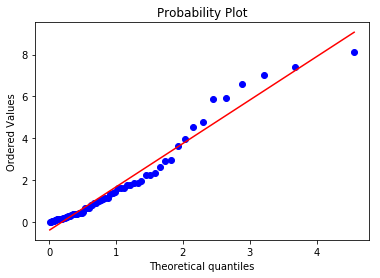



k = 3, size = 6
Number of negative jump times: 56
Mean: 1.3295357142857145


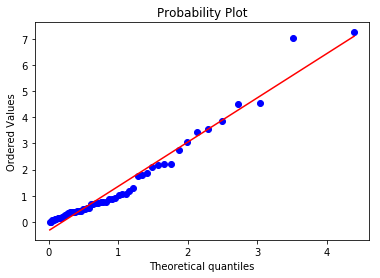



k = 3, size = 7
Number of negative jump times: 67
Mean: 3.0179104477611944


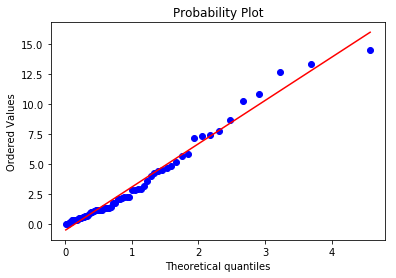



k = 3, size = 8
Number of negative jump times: 72
Mean: 2.065430555555556


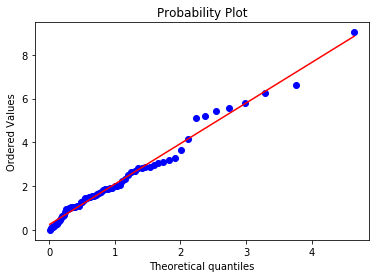



k = 3, size = 15
Number of negative jump times: 21
Mean: 4.289857142857143


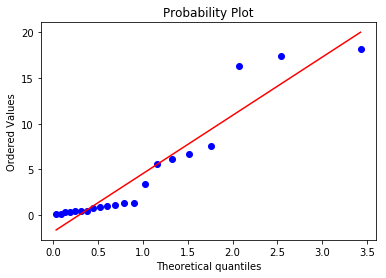



k = 4, size = 1
Number of negative jump times: 228
Mean: 1.8318157894736842


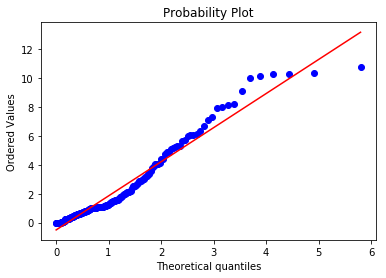



k = 4, size = 2
Number of negative jump times: 113
Mean: 1.517557522123894


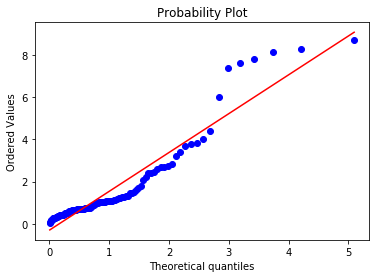



k = 4, size = 3
Number of negative jump times: 224
Mean: 0.8835


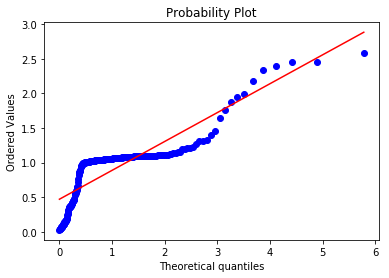



k = 4, size = 4
Number of negative jump times: 184
Mean: 0.7765163043478261


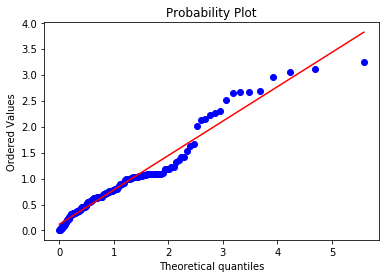



k = 4, size = 5
Number of negative jump times: 112
Mean: 0.7758571428571429


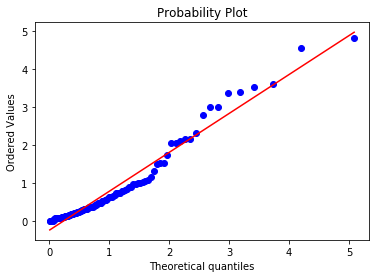



k = 4, size = 6
Number of negative jump times: 55
Mean: 2.515527272727273


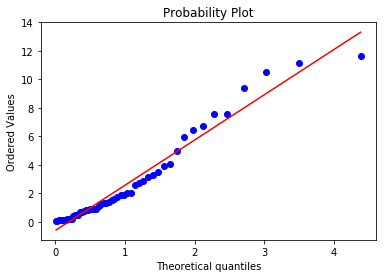



k = 4, size = 7
Number of negative jump times: 32
Mean: 0.7109687499999999


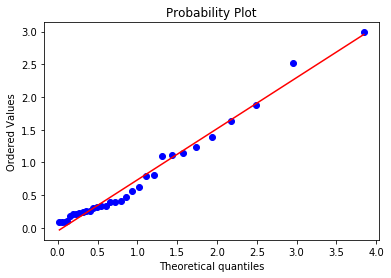



k = 4, size = 8
Number of negative jump times: 55
Mean: 2.044345454545454


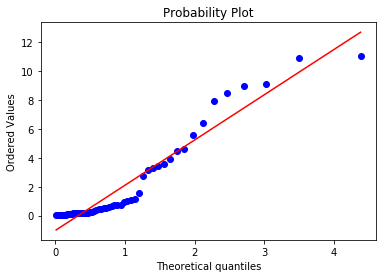



k = 4, size = 10
Number of negative jump times: 21
Mean: 0.48699999999999993


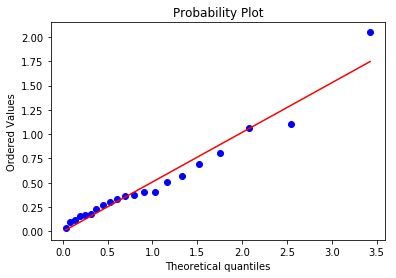



k = 4, size = 17
Number of negative jump times: 36
Mean: 5.061916666666666


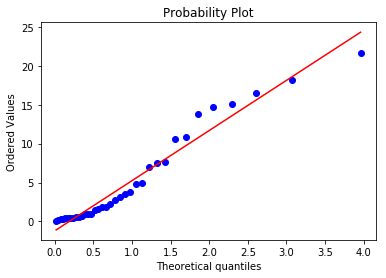



k = 4, size = 20
Number of negative jump times: 45
Mean: 10.964044444444445


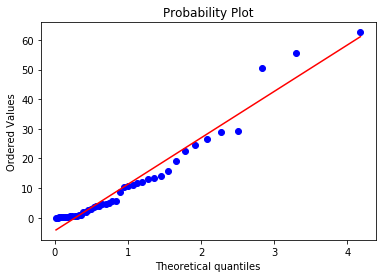



k = 5, size = 1
Number of negative jump times: 130
Mean: 4.145776923076922


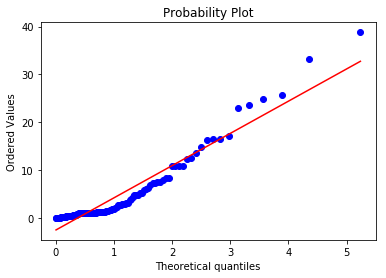



k = 5, size = 2
Number of negative jump times: 115
Mean: 1.998973913043478


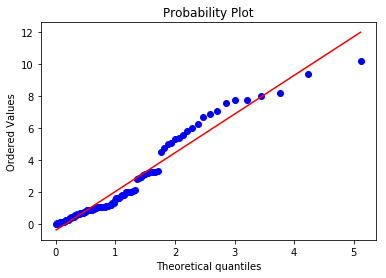



k = 5, size = 3
Number of negative jump times: 121
Mean: 2.139198347107438


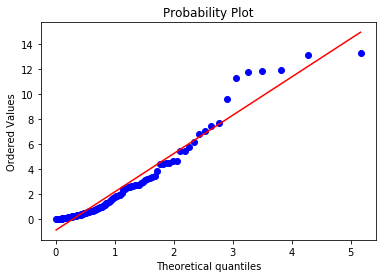



k = 5, size = 4
Number of negative jump times: 115
Mean: 1.4170521739130435


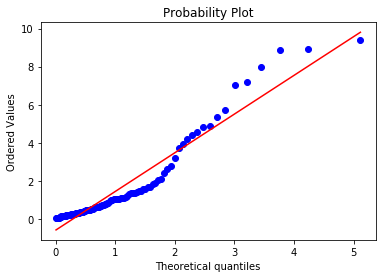



k = 6, size = 1
Number of negative jump times: 107
Mean: 1.1509810560747664


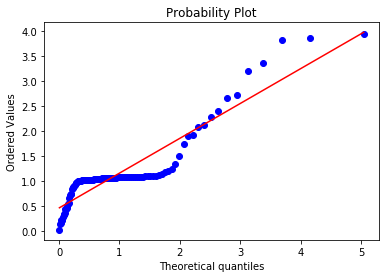



k = 6, size = 2
Number of negative jump times: 56
Mean: 2.8440714285714286


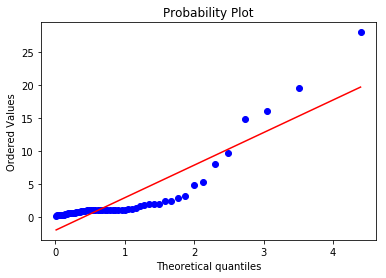



k = 6, size = 3
Number of negative jump times: 26
Mean: 11.00146153846154


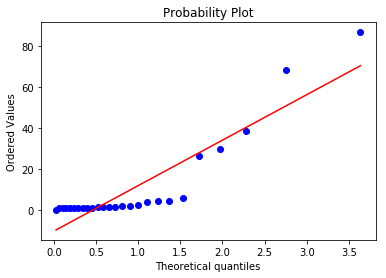



k = 6, size = 4
Number of negative jump times: 29
Mean: 8.641724137931034


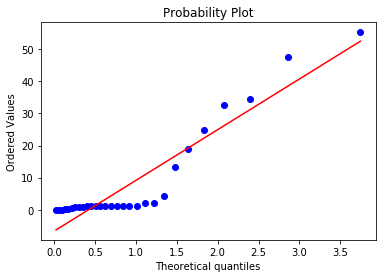



k = 6, size = 11
Number of negative jump times: 47
Mean: 1.0462127659574467


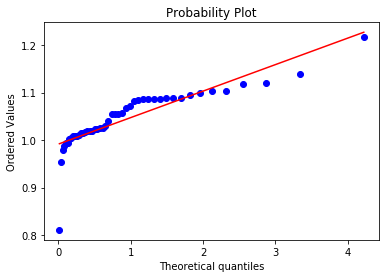



k = 6, size = 16
Number of negative jump times: 22
Mean: 4.486681818181818


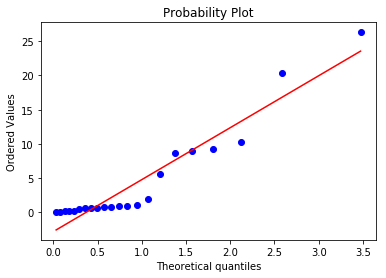



k = 6, size = 19
Number of negative jump times: 30
Mean: 1.9683000000000002


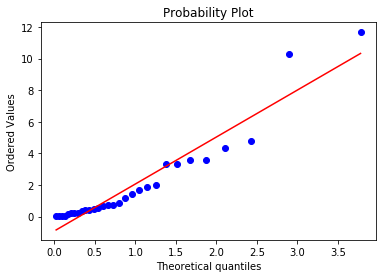



k = 7, size = 1
Number of negative jump times: 78
Mean: 17.51342307692308


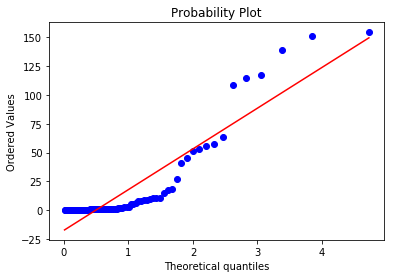



k = 7, size = 2
Number of negative jump times: 105
Mean: 1.262


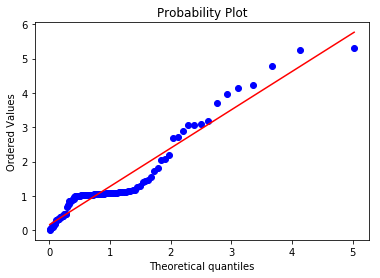



k = 7, size = 12
Number of negative jump times: 27
Mean: 34.28614814814814


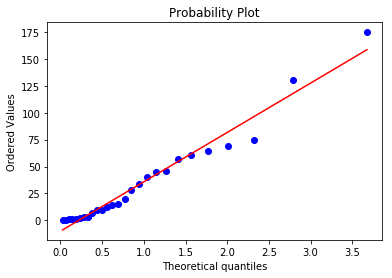



k = 8, size = 1
Number of negative jump times: 31
Mean: 1.215741935483871


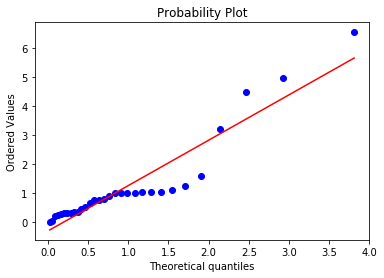



k = 8, size = 2
Number of negative jump times: 46
Mean: 2.990586956521739


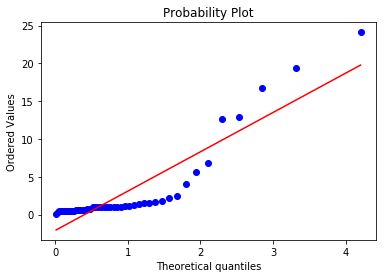



k = 8, size = 3
Number of negative jump times: 31
Mean: 18.86887096774193


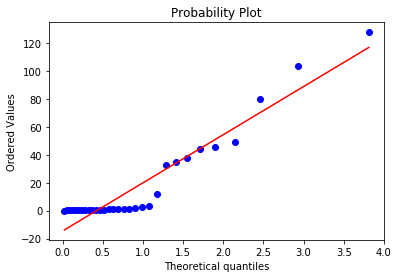



k = 8, size = 5
Number of negative jump times: 35
Mean: 2.4756285714285715


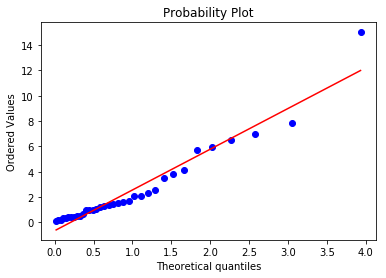



k = 8, size = 6
Number of negative jump times: 36
Mean: 1.4708888888888891


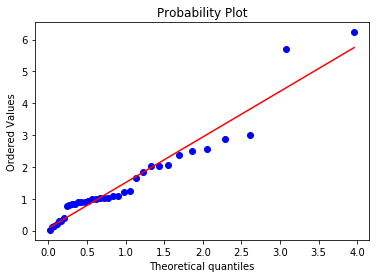



k = 9, size = 1
Number of negative jump times: 47
Mean: 1.2799361702127658


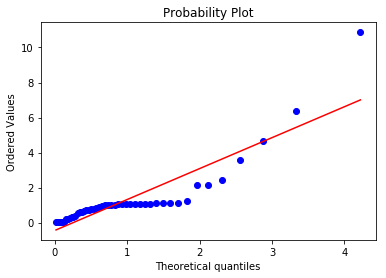



k = 9, size = 2
Number of negative jump times: 23
Mean: 141.4272608695652


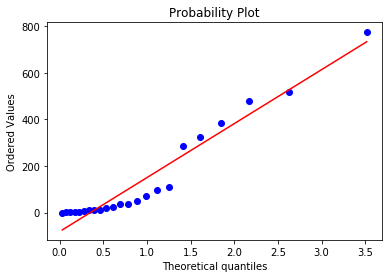



k = 10, size = 1
Number of negative jump times: 46
Mean: 75.58054347826088


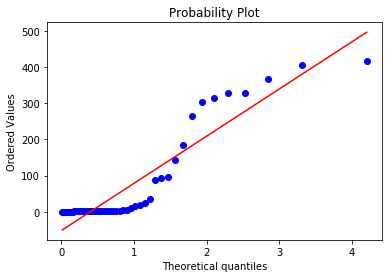

In [49]:
# Remove outliers
def without_outliers(data):
    if len(data) <= 3:
        return data
    quartiles = np.percentile(data,[25,50,75])
    IQR = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - 3*IQR
    upper_bound = quartiles[2] + 3*IQR
    return [d for d in data if d >= lower_bound and d <= upper_bound]


for k in time_between_events_pos:
    time_between_events_pos[k] = \
    OrderedDict([(s,without_outliers(ts)) for (s,ts) in time_between_events_pos[k].items()])
    time_between_events_pos[k] = \
    OrderedDict([(s,ts) for (s,ts) in time_between_events_pos[k].items() if len(ts) > 20])
# time_between_events_pos = OrderedDict([(k,d) for (k,d) in time_between_events_pos.items() if len(d) > 0])
        
for k in time_between_events_neg:
    time_between_events_neg[k] = \
    OrderedDict([(s,without_outliers(ts)) for (s,ts) in time_between_events_neg[k].items()])
    time_between_events_neg[k] = \
    OrderedDict([(s,ts) for (s,ts) in time_between_events_neg[k].items() if len(ts) > 20])    
# time_between_events_neg = OrderedDict([(k,d) for (k,d) in time_between_events_neg.items() if len(d) > 0])

       
for k,v in time_between_events_pos.items():
    for size,times in v.items():
        n = len(times)
        print("k = {}, size = {}".format(k,size))
        print("Number of positive jump times: {}".format(n))
        num_data_points = len(times)
        print("Mean: {}".format(np.mean(times)))
        probplot(times, dist=expon, plot=pylab)
        pylab.show()
        print("\n")

for k,v in time_between_events_neg.items():
    for size,times in v.items():
        n = len(times)
        print("k = {}, size = {}".format(k,size))
        print("Number of negative jump times: {}".format(n))
        num_data_points = len(times)
        print("Mean: {}".format(np.mean(times)))
        probplot(times, dist=expon, plot=pylab)
        pylab.show()
        print("\n")

# Compare to aribrtary exponential distribution

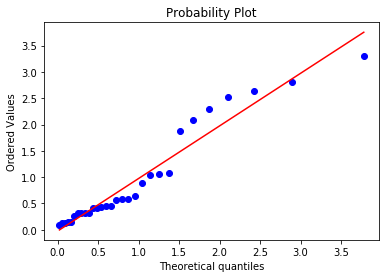

In [60]:
x = [np.random.exponential() for _ in range(30)]
kstest(x,'expon',args=(np.mean(x),))
probplot(x, dist=expon, plot=pylab)
pylab.show()

# Graph Arrival Rates

-10


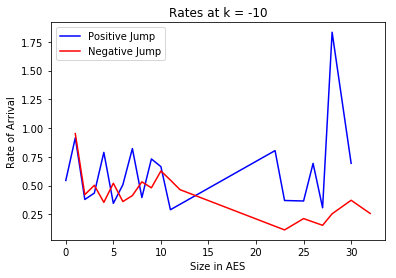

-9


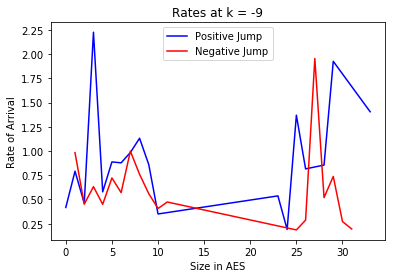

-8


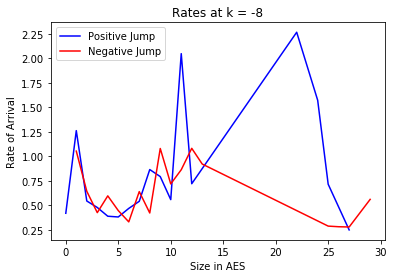

-7


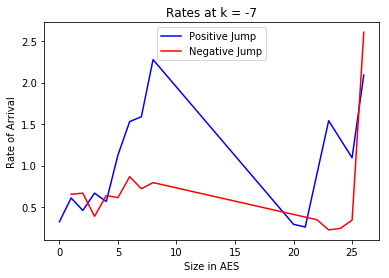

-6


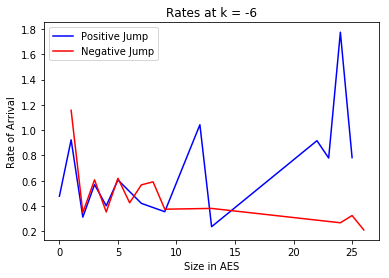

-5


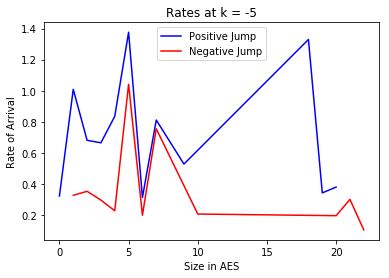

-4


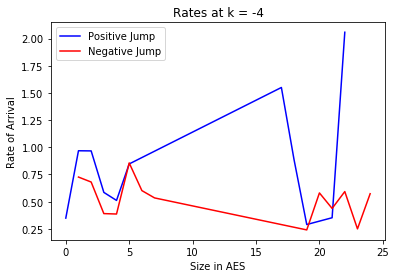

-3


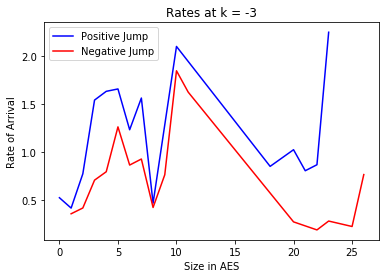

-2


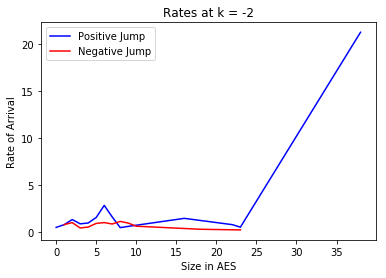

-1


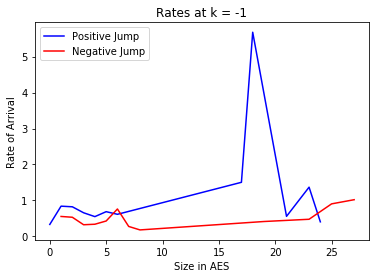

1


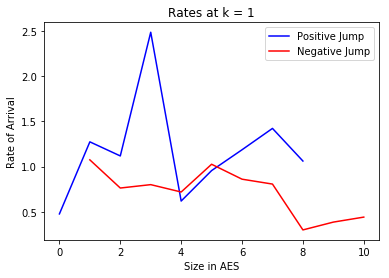

2


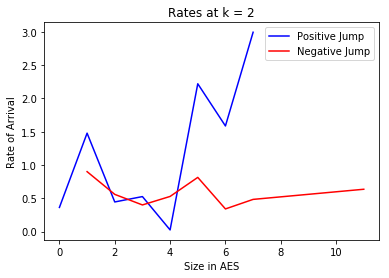

3


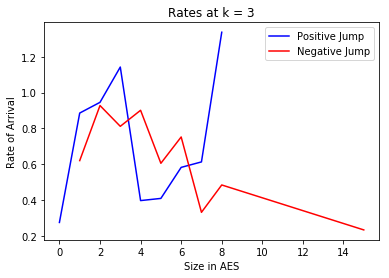

4


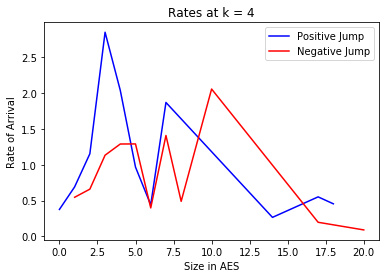

5


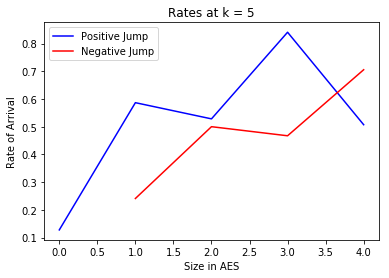

6


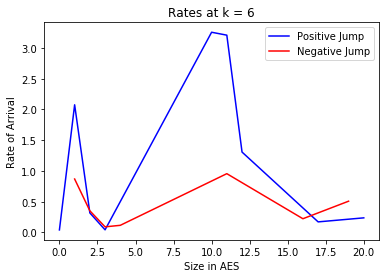

7


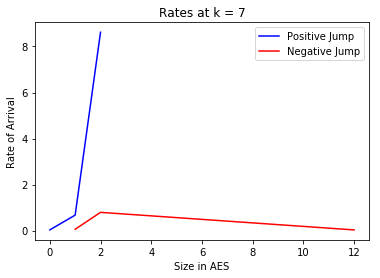

8


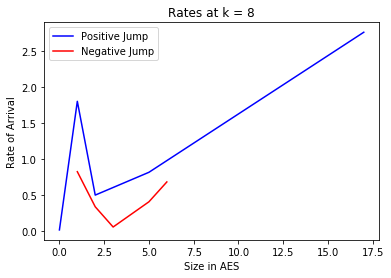

9


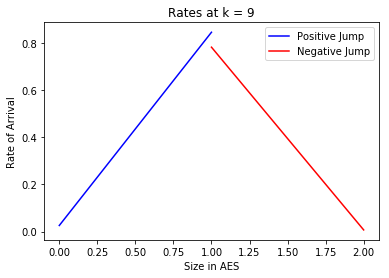

10


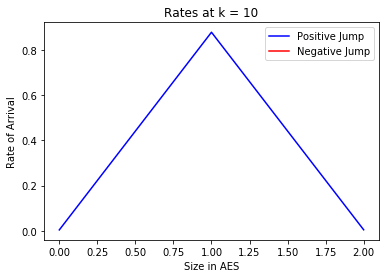

In [61]:
pos_rates_dict = OrderedDict([(k,OrderedDict()) for k in time_between_events_pos])
neg_rates_dict = OrderedDict([(k,OrderedDict()) for k in time_between_events_neg])

for k in pos_rates_dict:
    pos_rates_dict[k] = OrderedDict([(size,1/np.mean(times)) for size,times in time_between_events_pos[k].items()])
for k in neg_rates_dict:
    neg_rates_dict[k] = OrderedDict([(size,1/np.mean(times)) for size,times in time_between_events_neg[k].items()])

for k in range(-K,K+1):
    if k == 0:
        continue
    
    print(k)
        
    if len(pos_rates_dict[k]) > 0:
        pos_size,pos_rates = zip(*(pos_rates_dict[k].items()))
    else:
        pos_size,pos_rates = [],[]
        
    if len(neg_rates_dict[k]) > 0:
        neg_size,neg_rates = zip(*(neg_rates_dict[k].items()))
    else:
        neg_size,neg_rates = [],[]
        
    plt.plot(pos_size,pos_rates,'b')
    plt.plot(neg_size,neg_rates,'r')
    plt.xlabel('Size in AES')
    plt.ylabel('Rate of Arrival')
    plt.title('Rates at k = {}'.format(k))
    plt.legend(['Positive Jump', 'Negative Jump'])
    plt.show()
        
        

# Find (number of positive jumps - number of negative jumps) between time intervals of 1 minutes each

In [20]:
ending_time = updates[-1]['time'] + timedelta(seconds=1)
ending_time + timedelta(seconds = 1)
time_period_length = (ending_time - starting_time).total_seconds()

times = []
time = starting_time
while time <= ending_time:
    time += timedelta(seconds = 60)
    times.append(time)

n = len(times)

changes_at_each_k = OrderedDict([(k,[0 for _ in range(n)]) for k in range(-K,K+1) if k != 0])

i = 0
for u in combined_updates:
    if u['change'] < 0:
        changes_at_each_k[u['k']][i] -= 1
    else:
        changes_at_each_k[u['k']][i] += 1
        
    if u['time'] > times[i]:
        i += 1
        
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df = pd.DataFrame(changes_at_each_k)
correlations = df.corr().astype('object')

significances = correlations.copy()
for k1 in changes_at_each_k:
    for k2 in changes_at_each_k:
        res = pearsonr(changes_at_each_k[k1],changes_at_each_k[k2])
        significances[k1][k2] = res
significances

# Correlation Matrix
## Rows and columns are queue positions, the value is (correlation, p-value) where the p-value is Pearson's correlation
### Highlighted red are those that have correlation > 0.1

In [36]:
threshold = 0.10
def color_significant_red(val):
    global threshold
    if val[0] > 0.99999: # Same index
        color = 'green'
    else:
        color = 'red' if abs(val[0]) > threshold else 'black'
    return 'color: %s' % color

colored_table = significances.loc[-5:5,-5:5].style.applymap(color_significant_red)
colored_table = colored_table.format(lambda x: "{0:.3f},{1:.3f}".format(x[0],x[1]))
colored_table